In [2]:
import osmium as osm
import pandas as pd
import geopandas
import os.path
import os
import shapely.wkb as wkblib
wkbfab = osm.geom.WKBFactory()
import numpy as np
import shapely.geometry

from sklearn import tree
import graphviz
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
from sklearn import preprocessing
import jenkspy
from sklearn.metrics import PrecisionRecallDisplay

In [2]:
class AreaHandler(osm.SimpleHandler):
    def __init__(self):
        osm.SimpleHandler.__init__(self)
        self.num_polys = 0
        self.osm_data = []
        self.roads_data = []
        self.landuse_data = []
        self.amenity_data = []
        
    def count_polygons(self):
        self.num_polys += 1
        
    def way(self, w):
        try:
            wkb = wkbfab.create_linestring(w)
            line = wkblib.loads(wkb, hex=True)
            for tag in w.tags:
                if (tag.k=='highway'):
                    self.roads_data.append([w.id,
                                       tag.v,
                                       line])
        except Exception:
            pass    
        
    def area(self, a):
        try:
            wkb = wkbfab.create_multipolygon(a)
            self.count_polygons()
            # load into shapely
            poly = wkblib.loads(wkb, hex=True)
            for tag in a.tags:
                if (tag.k=='building'):
                    self.osm_data.append([a.id,                                   
                                    tag.v,
                                    list(poly.geoms)[0],
                                    list(dict(a.tags).keys()),
                                    dict(a.tags)])
                if (tag.k=='landuse'):
                    self.landuse_data.append([tag.v,
                                    list(poly.geoms)[0],
                                    ])
                if (tag.k == 'amenity'):
                    self.amenity_data.append([tag.v,
                                    list(poly.geoms)[0],
                                    ])
        except Exception:
            pass

In [3]:
# load official buildings
buildings_path = "/DATA2/dse313/group15/Datasets/Official/Fairfax_admin_buildings/Fairfax_admin_buildings.shp"
official_buildings = geopandas.read_file(buildings_path)

In [4]:
official_buildings.columns

Index(['OBJECTID', 'TYPE', 'geometry'], dtype='object')

In [5]:
official_buildings = official_buildings.rename(columns={'TYPE': 'official_type'})

In [6]:
official_buildings.shape

(275560, 3)

In [7]:
official_buildings.groupby(['official_type']).count()

,OBJECTID,geometry
official_type,,
C,5588,5588
I,1996,1996
MFR,5095,5095
MG,335,335
MH,1554,1554
MU,34,34
O,4271,4271
P,5043,5043
SFR,251644,251643


In [8]:
len(official_buildings['OBJECTID'].unique())

275560

In [9]:
official_buildings.drop(official_buildings[(official_buildings['official_type'] == 'MG') \
                                   | (official_buildings['official_type'] == 'O') \
                                   | (official_buildings['official_type'] == 'MH') \
                                   | (official_buildings['official_type'] == 'MU')].index, inplace = True)

official_buildings.reset_index(inplace=True, drop=True)

In [10]:
official_buildings.groupby(['official_type']).count()

,OBJECTID,geometry
official_type,,
C,5588,5588
I,1996,1996
MFR,5095,5095
P,5043,5043
SFR,251644,251643


In [11]:
official_buildings.shape

(269366, 3)

In [12]:
official_buildings['official_type'] = official_buildings['official_type'].apply(\
                                lambda x: 'RES' if (x == 'SFR' \
                                                    or x == 'MFR') else 'NON_RES')

In [13]:
official_buildings.groupby('official_type').count()

,OBJECTID,geometry
official_type,,
NON_RES,12627,12627
RES,256739,256738


In [14]:
areahandler = AreaHandler()
areahandler.apply_file("/DATA2/dse313/group15/Datasets/OSM/FFX_County_Buildings.osm.pbf", locations=True)
print("Number of polygons: %d" % areahandler.num_polys)

Number of polygons: 517121


In [15]:
len(areahandler.osm_data)

462512

In [16]:
# transform the list into a pandas DataFrame
data_colnames = ['id', 'building', 'geometry', 'all_tag_keys', 'all_tags']
df = pd.DataFrame(areahandler.osm_data, columns=data_colnames)

In [17]:
df.head()

,id,building,geometry,all_tag_keys,all_tags
0,11958664,yes,"POLYGON ((-77.0726877 39.0163947, -77.0725172 ...",[building],{'building': 'yes'}
1,45479154,airport_terminal,"POLYGON ((-77.4500588 38.9530699, -77.4500578 ...","[addr:city, addr:housenumber, addr:postcode, a...","{'addr:city': 'Dulles', 'addr:housenumber': '1..."
2,54579040,church,"POLYGON ((-77.108128 38.8682955, -77.1077849 3...","[addr:city, addr:housenumber, addr:postcode, a...","{'addr:city': 'Arlington', 'addr:housenumber':..."
3,54617714,school,"POLYGON ((-77.0655544 38.8133148, -77.0654762 ...","[addr:city, addr:housenumber, addr:postcode, a...","{'addr:city': 'Alexandria', 'addr:housenumber'..."
4,54622624,yes,"POLYGON ((-77.0507147 38.8120626, -77.0501268 ...","[addr:housenumber, addr:street, amenity, build...","{'addr:housenumber': '1100', 'addr:street': 'W..."


In [18]:
gdf = geopandas.GeoDataFrame(df, crs=4326, geometry='geometry')

<AxesSubplot:>

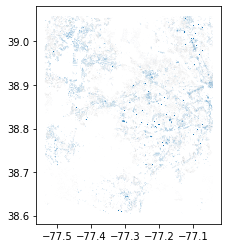

In [19]:
gdf.plot()

In [20]:
gdf.head()

,id,building,geometry,all_tag_keys,all_tags
0,11958664,yes,"POLYGON ((-77.07269 39.01639, -77.07252 39.016...",[building],{'building': 'yes'}
1,45479154,airport_terminal,"POLYGON ((-77.45006 38.95307, -77.45006 38.953...","[addr:city, addr:housenumber, addr:postcode, a...","{'addr:city': 'Dulles', 'addr:housenumber': '1..."
2,54579040,church,"POLYGON ((-77.10813 38.86830, -77.10778 38.868...","[addr:city, addr:housenumber, addr:postcode, a...","{'addr:city': 'Arlington', 'addr:housenumber':..."
3,54617714,school,"POLYGON ((-77.06555 38.81331, -77.06548 38.813...","[addr:city, addr:housenumber, addr:postcode, a...","{'addr:city': 'Alexandria', 'addr:housenumber'..."
4,54622624,yes,"POLYGON ((-77.05071 38.81206, -77.05013 38.811...","[addr:housenumber, addr:street, amenity, build...","{'addr:housenumber': '1100', 'addr:street': 'W..."


In [21]:
gdf.groupby('building').count().sort_values(by=['building'], inplace=False, ascending=True)

,id,geometry,all_tag_keys,all_tags
building,,,,
Forum,1,1,1,1
Mixed_Use,1,1,1,1
Pumping_Station,1,1,1,1
Religious,1,1,1,1
Townhouse,46,46,46,46
...,...,...,...,...
water_tower,6,6,6,6
yes,293531,293531,293531,293531
yes;office,1,1,1,1


In [22]:
# transform the list into a pandas DataFrame
land_colnames = ['landuse', 'geometry']
land_df = pd.DataFrame(areahandler.landuse_data, columns=land_colnames)

In [23]:
land_df.shape

(13494, 2)

In [24]:
land_df.head()

,landuse,geometry
0,retail,"POLYGON ((-77.0870385 38.8083899, -77.0829273 ..."
1,retail,"POLYGON ((-77.1131912 38.8128709, -77.1130524 ..."
2,recreation_ground,"POLYGON ((-77.0878901 38.8928598, -77.0877219 ..."
3,grass,"POLYGON ((-77.1257637 38.9404454, -77.1256642 ..."
4,brownfield,"POLYGON ((-77.1356511 38.8153842, -77.135627 3..."


In [25]:
land_df.groupby('landuse').count()

,geometry
landuse,
allotments,28
animal_keeping,2
basin,41
brownfield,11
cemetery,133
churchyard,2
commercial,348
construction,207
depot,2


In [26]:
non_res = ['commercial', 'retail','industrial','grass','plant_nursery','quarry','railway','government',\
            'institutional']
land_df['landuse'] = land_df['landuse'].apply(\
                                lambda x: 'non_res' if x in non_res else x)

In [27]:
land_df.groupby('landuse').count()

,geometry
landuse,
allotments,28
animal_keeping,2
basin,41
brownfield,11
cemetery,133
churchyard,2
construction,207
depot,2
education,5


In [28]:
land_gdf = geopandas.GeoDataFrame(land_df, crs=4326, geometry='geometry')

In [29]:
gdf.shape

(462512, 5)

In [30]:
land_gdf.shape

(13494, 2)

In [31]:
buildings_land = gdf.sjoin(land_gdf, how="left", predicate='intersects')

In [32]:
buildings_land.shape

(468712, 7)

In [33]:
buildings_land.drop_duplicates(subset='id',inplace=True)

In [34]:
buildings_land.shape

(462512, 7)

In [35]:
buildings_land.head()

,id,building,geometry,all_tag_keys,all_tags,index_right,landuse
0,11958664,yes,"POLYGON ((-77.07269 39.01639, -77.07252 39.016...",[building],{'building': 'yes'},772.0,residential
1,45479154,airport_terminal,"POLYGON ((-77.45006 38.95307, -77.45006 38.953...","[addr:city, addr:housenumber, addr:postcode, a...","{'addr:city': 'Dulles', 'addr:housenumber': '1...",NaN,NaN
2,54579040,church,"POLYGON ((-77.10813 38.86830, -77.10778 38.868...","[addr:city, addr:housenumber, addr:postcode, a...","{'addr:city': 'Arlington', 'addr:housenumber':...",13466.0,religious
3,54617714,school,"POLYGON ((-77.06555 38.81331, -77.06548 38.813...","[addr:city, addr:housenumber, addr:postcode, a...","{'addr:city': 'Alexandria', 'addr:housenumber'...",NaN,NaN
4,54622624,yes,"POLYGON ((-77.05071 38.81206, -77.05013 38.811...","[addr:housenumber, addr:street, amenity, build...","{'addr:housenumber': '1100', 'addr:street': 'W...",NaN,NaN


In [36]:
buildings_land.rename(columns={'index_right': 'index_landuse'},inplace=True)
buildings_land['landuse'] = \
            buildings_land['landuse'].apply(lambda x: 'no_landuse' if pd.isnull(x) else x)
buildings_land.reset_index(inplace=True, drop=True)

In [37]:
buildings_land[buildings_land['landuse'] == 'no_landuse'].shape

(281233, 7)

In [38]:
len(buildings_land.index_landuse.unique())

4303

In [39]:
buildings_land.head()

,id,building,geometry,all_tag_keys,all_tags,index_landuse,landuse
0,11958664,yes,"POLYGON ((-77.07269 39.01639, -77.07252 39.016...",[building],{'building': 'yes'},772.0,residential
1,45479154,airport_terminal,"POLYGON ((-77.45006 38.95307, -77.45006 38.953...","[addr:city, addr:housenumber, addr:postcode, a...","{'addr:city': 'Dulles', 'addr:housenumber': '1...",NaN,no_landuse
2,54579040,church,"POLYGON ((-77.10813 38.86830, -77.10778 38.868...","[addr:city, addr:housenumber, addr:postcode, a...","{'addr:city': 'Arlington', 'addr:housenumber':...",13466.0,religious
3,54617714,school,"POLYGON ((-77.06555 38.81331, -77.06548 38.813...","[addr:city, addr:housenumber, addr:postcode, a...","{'addr:city': 'Alexandria', 'addr:housenumber'...",NaN,no_landuse
4,54622624,yes,"POLYGON ((-77.05071 38.81206, -77.05013 38.811...","[addr:housenumber, addr:street, amenity, build...","{'addr:housenumber': '1100', 'addr:street': 'W...",NaN,no_landuse


In [40]:
buildings_land.groupby('landuse').count()

,id,building,geometry,all_tag_keys,all_tags,index_landuse
landuse,,,,,,
animal_keeping,27,27,27,27,27,27
brownfield,7,7,7,7,7,7
cemetery,108,108,108,108,108,108
churchyard,9,9,9,9,9,9
construction,521,521,521,521,521,521
depot,5,5,5,5,5,5
education,3,3,3,3,3,3
farmland,22,22,22,22,22,22
farmyard,23,23,23,23,23,23


In [41]:
buildings_land.groupby(['landuse','building']).count().head(50)

id  geometry  all_tag_keys  all_tags  \
landuse        building                                                
animal_keeping roof              3         3             3         3   
               stable            1         1             1         1   
               static_caravan    1         1             1         1   
               yes              22        22            22        22   
brownfield     yes               7         7             7         7   
cemetery       chapel            1         1             1         1   
               church            2         2             2         2   
               house             1         1             1         1   
               industrial        1         1             1         1   
               office            1         1             1         1   
               shed              1         1             1         1   
               university        1         1             1         1   
               yes             100       100           100       100   
churchyard     church            1         1             1         1   
               greenhouse        1         1             1         1   
               shed              2         2             2         2   
               yes               5         5             5         5   
construction   apartments       11        11            11        11   
               commercial        7         7             7         7   
               construction    327       327           327       327   
               detached          1         1             1         1   
               garage            1         1             1         1   
               house            21        21            21        21   
               industrial        1         1             1         1   
               office            2         2             2         2   
               parking           2         2             2         2   
               public            1         1             1         1   
               residential       6         6             6         6   
               retail            5         5             5         5   
               roof              2         2             2         2   
               school            1         1             1         1   
               terrace          57        57            57        57   
               train_station     1         1             1         1   
               yes              75        75            75        75   
depot          yes               5         5             5         5   
education      school            1         1             1         1   
               yes               2         2             2         2   
farmland       barn              3         3             3         3   
               house             1         1             1         1   
               shed              2         2             2         2   
               yes              16        16            16        16   
farmyard       apartments        1         1             1         1   
               barn              1         1             1         1   
               house             1         1             1         1   
               shed              4         4             4         4   
               stable            2         2             2         2   
               yes              14        14            14        14   
flowerbed      house             1         1             1         1   
               yes               1         1             1         1   
forest         garage            2         2             2         2   

                               index_landuse  
landuse        building                       
animal_keeping roof                        3  
               stable                      1  
               static_caravan              1  
               yes                        22  
brown

In [42]:
buildings_land['land_building'] = buildings_land.apply(lambda x: \
    x['landuse'] if x['building'] == 'yes' else x['building'], axis=1)

In [43]:
buildings_land.groupby(['landuse','land_building']).count().head(50)

id  building  geometry  all_tag_keys  \
landuse        land_building                                           
animal_keeping animal_keeping   22        22        22            22   
               roof              3         3         3             3   
               stable            1         1         1             1   
               static_caravan    1         1         1             1   
brownfield     brownfield        7         7         7             7   
cemetery       cemetery        100       100       100           100   
               chapel            1         1         1             1   
               church            2         2         2             2   
               house             1         1         1             1   
               industrial        1         1         1             1   
               office            1         1         1             1   
               shed              1         1         1             1   
               university        1         1         1             1   
churchyard     church            1         1         1             1   
               churchyard        5         5         5             5   
               greenhouse        1         1         1             1   
               shed              2         2         2             2   
construction   apartments       11        11        11            11   
               commercial        7         7         7             7   
               construction    402       402       402           402   
               detached          1         1         1             1   
               garage            1         1         1             1   
               house            21        21        21            21   
               industrial        1         1         1             1   
               office            2         2         2             2   
               parking           2         2         2             2   
               public            1         1         1             1   
               residential       6         6         6             6   
               retail            5         5         5             5   
               roof              2         2         2             2   
               school            1         1         1             1   
               terrace          57        57        57            57   
               train_station     1         1         1             1   
depot          depot             5         5         5             5   
education      education         2         2         2             2   
               school            1         1         1             1   
farmland       barn              3         3         3             3   
               farmland         16        16        16            16   
               house             1         1         1             1   
               shed              2         2         2             2   
farmyard       apartments        1         1         1             1   
               barn              1         1         1             1   
               farmyard         14        14        14            14   
               house             1         1         1             1   
               shed              4         4         4             4   
               stable            2         2         2             2   
flowerbed      flowerbed         1         1         1             1   
               house             1         1         1             1   
forest         forest           28        28        28            28   
               garage            2         2         2             2   

                               all_tags  index_landuse  
landuse        land_building                            
animal_keeping animal_keeping        22             22  
               roof                   3              3  
               stable                 1              1  
  

In [44]:
buildings_land.groupby(['landuse','land_building']).count().tail(50)

id  building  geometry  all_tag_keys  \
landuse       land_building                                                 
religious     gatehouse               1         1         1             1   
              house                   2         2         2             2   
              industrial              1         1         1             1   
              parking                 1         1         1             1   
              religious              67        67        67            67   
              residential             1         1         1             1   
              school                  3         3         3             3   
              shed                    8         8         8             8   
              temple                  1         1         1             1   
residential   Townhouse               2         2         2             2   
              apartments           3426      3426      3426          3426   
              attached               66        66        66            66   
              cabin                   1         1         1             1   
              canopy                  4         4         4             4   
              carport                 9         9         9             9   
              church                 12        12        12            12   
              civic                  10        10        10            10   
              commercial             25        25        25            25   
              condominium             1         1         1             1   
              detached            10866     10866     10866         10866   
              gar                     1         1         1             1   
              garage               2239      2239      2239          2239   
              garages               134       134       134           134   
              hotel                   3         3         3             3   
              house               48215     48215     48215         48215   
              iy                      1         1         1             1   
              kindergarten            2         2         2             2   
              manufacture             1         1         1             1   
              no                      4         4         4             4   
              office                 17        17        17            17   
              parking                49        49        49            49   
              pavilion                1         1         1             1   
              public                  3         3         3             3   
              q                       1         1         1             1   
              residential         83893     83893     83893         83893   
              retail                  2         2         2             2   
              roof                  266       266       266           266   
              ruins                   1         1         1             1   
              school                 20        20        20            20   
              semidetached_house   1897      1897      1897          1897   
              shed                 4620      4620      4620          4620   
              terrace             14976     14976     14976         14976   
              townhouse              44        44        44            44   
              water_tower             1         1         1             1   
training      training                4         4         4             4   
village_green university              3         3         3             3   
              village_green           2         2         2             2   
vineyard      vineyard                2         2         2             2   
yes           university              1         1         1             1   
              yes                     2         2         2             2   

                                

In [45]:
def enrich_buildings(buildings_land,tags_list):
    for tag_val in tags_list:
        buildings_land['land_building'] = buildings_land.apply(lambda x: \
            tag_val if x['landuse'] == tag_val else x['land_building'], axis=1)

    return buildings_land

In [46]:
tags_list = ['residential','commercial','religious','recreation_ground','cemetery',\
            'construction','farmland','farmyard','forest','military']
buildings_land = enrich_buildings(buildings_land,tags_list)

In [47]:
buildings_land.groupby(['landuse','land_building']).count().head(50)

id  building  geometry  \
landuse                 land_building                                       
animal_keeping          animal_keeping             22        22        22   
                        roof                        3         3         3   
                        stable                      1         1         1   
                        static_caravan              1         1         1   
brownfield              brownfield                  7         7         7   
cemetery                cemetery                  108       108       108   
churchyard              church                      1         1         1   
                        churchyard                  5         5         5   
                        greenhouse                  1         1         1   
                        shed                        2         2         2   
construction            construction              521       521       521   
depot                   depot                       5         5         5   
education               education                   2         2         2   
                        school                      1         1         1   
farmland                farmland                   22        22        22   
farmyard                farmyard                   23        23        23   
flowerbed               flowerbed                   1         1         1   
                        house                       1         1         1   
forest                  forest                     33        33        33   
garage                  garage                      2         2         2   
                        retail                      1         1         1   
garages                 garages                     1         1         1   
greenfield              greenfield                  5         5         5   
greenhouse_horticulture greenhouse_horticulture     1         1         1   
landfill                landfill                    6         6         6   
meadow                  meadow                     15        15        15   
                        roof                        1         1         1   
military                military                 1977      1977      1977   
no_landuse              Forum                       1         1         1   
                        Mixed_Use                   1         1         1   
                        Pumping_Station             1         1         1   
                        Religious                   1         1         1   
                        Townhouse                  44        44        44   
                        Utility_Suubstation         1         1         1   
                        airport_terminal            6         6         6   
                        apartments               1954      1954      1954   
                        armory                      1         1         1   
                        attached                   10        10        10   
                        barn                        9         9         9   
                        bleachers                   3         3         3   
                        boathouse                  13        13        13   
                        bridge                      3         3         3   
                        bunker                      4         4         4   
                        cabin                       2         2         2   
                        canopy                     14        14        14   
                        carport                     2         2         2   
                        central_office             18        18        18   
                        chapel                      3         3         3   
                        church                    295       295       295   
                        church;yes                  1         1         1   

                                              

In [48]:
buildings_land.groupby(['landuse','land_building']).count().tail(50)

id  building  geometry  all_tag_keys  \
landuse           land_building                                                 
non_res           college                 6         6         6             6   
                  commecial               1         1         1             1   
                  commercial            375       375       375           375   
                  construction            4         4         4             4   
                  data_center           107       107       107           107   
                  detached               29        29        29            29   
                  doctor                  1         1         1             1   
                  fire_station            1         1         1             1   
                  garage                 41        41        41            41   
                  gatehouse               2         2         2             2   
                  government              4         4         4             4   
                  grandstand             13        13        13            13   
                  greenhouse             15        15        15            15   
                  hangar                  4         4         4             4   
                  health                  1         1         1             1   
                  hotel                  13        13        13            13   
                  house                 209       209       209           209   
                  industrial            250       250       250           250   
                  kindergarten            8         8         8             8   
                  manufacture             1         1         1             1   
                  military                1         1         1             1   
                  no                      3         3         3             3   
                  non_res              4761      4761      4761          4761   
                  office                199       199       199           199   
                  parking                86        86        86            86   
                  public                  3         3         3             3   
                  residential            13        13        13            13   
                  retail                813       813       813           813   
                  roof                  241       241       241           241   
                  school                 65        65        65            65   
                  service                 2         2         2             2   
                  shed                   57        57        57            57   
                  shelter                 1         1         1             1   
                  static_caravan          1         1         1             1   
                  storage_tank            7         7         7             7   
                  supermarket             1         1         1             1   
                  terrace                 9         9         9             9   
                  university             16        16        16            16   
                  warehouse              17        17        17            17   
                  water_tower             4         4         4             4   
park              park                    1         1         1             1   
recreation_ground recreation_ground     121       121       121           121   
religious         religious             112       112       112           112   
residential       residential        170813    170813    170813        170813   
training          training                4         4         4             4   
village_green     university              3         3         3             3   
                  village_green           2         2         2             2   
vineyard          vineyard                2         2         2         

In [49]:
buildings_land.groupby(['land_building']).count().head(50)

,id,building,geometry,all_tag_keys,all_tags,index_landuse,landuse
land_building,,,,,,,
Forum,1,1,1,1,1,0,1
Mixed_Use,1,1,1,1,1,0,1
Pumping_Station,1,1,1,1,1,0,1
Religious,1,1,1,1,1,0,1
Townhouse,44,44,44,44,44,0,44
Utility_Suubstation,1,1,1,1,1,0,1
abandoned,1,1,1,1,1,1,1
airport_terminal,6,6,6,6,6,0,6
animal_keeping,22,22,22,22,22,22,22


In [50]:
buildings_land.shape

(462512, 8)

In [51]:
official_buildings.shape

(269366, 3)

In [52]:
buildings_gdf = buildings_land.sjoin(official_buildings, how="inner", predicate='intersects')
buildings_gdf.rename(columns={'index_right': 'index_official'}, inplace=True)

In [53]:
buildings_gdf.shape

(206813, 11)

In [54]:
buildings_gdf

,id,building,geometry,all_tag_keys,all_tags,index_landuse,landuse,land_building,index_official,OBJECTID,official_type
1,45479154,airport_terminal,"POLYGON ((-77.45006 38.95307, -77.45006 38.953...","[addr:city, addr:housenumber, addr:postcode, a...","{'addr:city': 'Dulles', 'addr:housenumber': '1...",NaN,no_landuse,airport_terminal,92301,94276,NON_RES
2244,122227790,airport_terminal,"POLYGON ((-77.45205 38.95196, -77.45125 38.951...","[addr:city, addr:housenumber, addr:postcode, a...","{'addr:city': 'Dulles', 'addr:housenumber': '4...",NaN,no_landuse,airport_terminal,92301,94276,NON_RES
2251,122241826,airport_terminal,"POLYGON ((-77.44745 38.95194, -77.44745 38.951...","[addr:city, addr:housenumber, addr:postcode, a...","{'addr:city': 'Dulles', 'addr:housenumber': '4...",NaN,no_landuse,airport_terminal,92301,94276,NON_RES
2252,122241844,yes,"POLYGON ((-77.44833 38.95147, -77.44801 38.951...","[aeroway, building]","{'aeroway': 'terminal', 'building': 'yes'}",NaN,no_landuse,no_landuse,92301,94276,NON_RES
461727,2047593418,yes,"POLYGON ((-77.45001 38.95145, -77.44989 38.951...","[addr:city, addr:housenumber, addr:postcode, a...","{'addr:city': 'Dulles', 'addr:housenumber': '4...",NaN,no_landuse,no_landuse,92301,94276,NON_RES
...,...,...,...,...,...,...,...,...,...,...,...
462467,2051910056,house,"POLYGON ((-77.38646 38.77953, -77.38642 38.779...","[addr:city, addr:country, addr:housenumber, ad...","{'addr:city': 'Clifton', 'addr:country': 'US',...",NaN,no_landuse,house,23435,23946,RES
462468,2051910058,house,"POLYGON ((-77.38615 38.77971, -77.38611 38.779...","[addr:city, addr:country, addr:housenumber, ad...","{'addr:city': 'Clifton', 'addr:country': 'US',...",NaN,no_landuse,house,21072,21551,RES
462469,2051910060,house,"POLYGON ((-77.38625 38.77991, -77.38619 38.779...","[addr:city, addr:country, addr:housenumber, ad...","{'addr:city': 'Clifton', 'addr:country': 'US',...",NaN,no_landuse,house,23442,23953,RES
462470,2051910062,house,"POLYGON ((-77.38640 38.78004, -77.38634 38.779...","[addr:city, addr:country, addr:housenumber, ad...","{'addr:city': 'Clifton', 'addr:country': 'US',...",NaN,no_landuse,house,22992,23501,RES


In [55]:
buildings_gdf.drop_duplicates(subset='id',inplace=True)

In [56]:
buildings_gdf.shape

(204672, 11)

In [57]:
buildings_gdf.groupby(['landuse','land_building','official_type',]).count().head(50)

id  building  geometry  \
landuse      land_building    official_type                             
cemetery     cemetery         NON_RES          13        13        13   
                              RES               3         3         3   
construction construction     NON_RES          23        23        23   
                              RES              15        15        15   
depot        depot            NON_RES           5         5         5   
farmland     farmland         NON_RES           7         7         7   
                              RES              10        10        10   
farmyard     farmyard         NON_RES           8         8         8   
                              RES               1         1         1   
flowerbed    house            RES               1         1         1   
forest       forest           NON_RES           4         4         4   
                              RES              19        19        19   
military     military         NON_RES        1333      1333      1333   
no_landuse   Pumping_Station  RES               1         1         1   
             Townhouse        RES              44        44        44   
             airport_terminal NON_RES           6         6         6   
             apartments       NON_RES          14        14        14   
                              RES             557       557       557   
             attached         RES               9         9         9   
             barn             RES               2         2         2   
             boathouse        NON_RES           1         1         1   
                              RES              11        11        11   
             bridge           NON_RES           1         1         1   
             bunker           NON_RES           4         4         4   
             cabin            NON_RES           1         1         1   
             canopy           NON_RES          11        11        11   
                              RES               2         2         2   
             central_office   NON_RES           7         7         7   
                              RES               4         4         4   
             chapel           RES               2         2         2   
             church           NON_RES          10        10        10   
                              RES              15        15        15   
             civic            NON_RES           5         5         5   
                              RES               1         1         1   
             college          NON_RES           2         2         2   
                              RES               2         2         2   
             commercial       NON_RES         389       389       389   
                              RES              33        33        33   
             construction     NON_RES           1         1         1   
                              RES               1         1         1   
             data_center      NON_RES           1         1         1   
             detached         NON_RES           1         1         1   
                              RES            5674      5674      5674   
             dormitory        RES               1         1         1   
             fire_station     NON_RES           1         1         1   
             foundation       RES               1         1         1   
             garage           NON_RES           5         5         5   
                              RES             331       331       331   
             garages          NON_RES           2         2         2   
             government       NON_RES           3         3         3   

                                             all_tag_keys  all_tags  \
landuse      land_building    official_type                           
cemetery     cemetery         NON_RES                  13        13   
                              RES    

In [58]:
buildings_gdf.groupby(['landuse','land_building','official_type',]).count().tail(50)

id  building  geometry  \
landuse           land_building     official_type                              
no_landuse        terrace           RES             1336      1336      1336   
                  townhome          RES              200       200       200   
                  townhouse         RES               74        74        74   
                  train_station     NON_RES            9         9         9   
                  transportation    NON_RES            1         1         1   
                  turning_circle    RES               17        17        17   
                  warehouse         NON_RES           20        20        20   
non_res           apartments        NON_RES            2         2         2   
                                    RES                4         4         4   
                  canopy            NON_RES           12        12        12   
                  central_office    NON_RES            1         1         1   
                  commecial         NON_RES            1         1         1   
                  commercial        NON_RES          146       146       146   
                                    RES                6         6         6   
                  construction      NON_RES            1         1         1   
                  data_center       NON_RES            6         6         6   
                  detached          NON_RES           24        24        24   
                  fire_station      NON_RES            1         1         1   
                  garage            NON_RES            4         4         4   
                  greenhouse        RES                1         1         1   
                  hangar            NON_RES            3         3         3   
                  hotel             NON_RES            4         4         4   
                  house             RES                4         4         4   
                  industrial        NON_RES           18        18        18   
                  manufacture       NON_RES            1         1         1   
                  no                NON_RES            2         2         2   
                  non_res           NON_RES         1487      1487      1487   
                                    RES               34        34        34   
                  office            NON_RES          132       132       132   
                  parking           NON_RES           13        13        13   
                                    RES                1         1         1   
                  public            NON_RES            1         1         1   
                  residential       NON_RES            5         5         5   
                  retail            NON_RES          463       463       463   
                                    RES                2         2         2   
                  roof              NON_RES           85        85        85   
                  school            NON_RES           20        20        20   
                  service           NON_RES            1         1         1   
                  shed              NON_RES            2         2         2   
                                    RES                1         1         1   
                  supermarket       NON_RES            1         1         1   
                  warehouse         NON_RES           12        12        12   
recreation_ground recreation_ground NON_RES            3         3         3   
                                    RES               16        16        16   
religious         religious         NON_RES            1         1         1   
                                    RES                4         4         4   
residential       residential       NON_RES          312       312       312   
                                    RES            41223     41223     41223   
training          training          NON_RES           

In [59]:
len(areahandler.roads_data)

232528

In [60]:
# transform the list of roads into a pandas DataFrame
roads_colnames = ['id', 'highway', 'geometry']
roads_df = pd.DataFrame(areahandler.roads_data, columns=roads_colnames)

In [61]:
roads_df.head()

,id,highway,geometry
0,4681060,service,"LINESTRING (-77.0482543 38.8338858, -77.048357..."
1,4681062,service,"LINESTRING (-77.0514882 38.8347737, -77.051376..."
2,4681074,service,"LINESTRING (-77.1296818 38.8530663, -77.129825..."
3,4681075,service,"LINESTRING (-77.1260163 38.8503773, -77.126611..."
4,4681076,primary,"LINESTRING (-77.1255015 38.8487522, -77.126585..."


In [62]:
roads_df.shape

(232528, 3)

In [63]:
road_categories = roads_df.groupby(['highway'])['id'].count().reset_index(name="count")

In [64]:
road_categories

,highway,count
0,bridleway,64
1,bus_stop,8
2,busway,2
3,construction,324
4,corridor,67
5,cycleway,2593
6,elevator,1
7,footway,47339
8,living_street,220
9,motorway,1828


In [65]:
roads_cat1 = roads_df[(roads_df['highway'] == 'residential') | (roads_df['highway'] == 'living_street')]

In [66]:
roads_cat1 = roads_cat1.assign(highway='residential')

In [67]:
roads_cat1.shape

(40413, 3)

In [68]:
roads_cat1.groupby('highway').count()

,id,geometry
highway,,
residential,40413,40413


In [69]:
roads_cat1 = geopandas.GeoDataFrame(roads_cat1,crs="EPSG:4326",geometry='geometry')

In [70]:
roads_list = ['primary', 'secondary','tertiary']
roads_cat2 = roads_df[roads_df['highway'].isin(roads_list)]

In [71]:
roads_cat2 = roads_cat2.assign(highway='non_res_road')

In [72]:
roads_cat2.shape

(15350, 3)

In [73]:
roads_cat2.groupby('highway').count()

,id,geometry
highway,,
non_res_road,15350,15350


In [74]:
roads_cat2 = geopandas.GeoDataFrame(roads_cat2,crs="EPSG:4326",geometry='geometry')

In [75]:
roads_cat3 = roads_df[(roads_df['highway'] == 'motorway') | (roads_df['highway'] == 'trunk')]

In [76]:
roads_cat3 = roads_cat3.assign(highway='roads_cat3')

In [77]:
roads_cat3.shape

(3708, 3)

In [78]:
roads_cat3.groupby('highway').count()

,id,geometry
highway,,
roads_cat3,3708,3708


In [79]:
roads_cat3 = geopandas.GeoDataFrame(roads_cat3,crs="EPSG:4326",geometry='geometry')

In [80]:
roads_cat4 = roads_df[(roads_df['highway'] == 'service')]

In [81]:
roads_cat4.shape

(108052, 3)

In [82]:
roads_cat4.groupby('highway').count()

,id,geometry
highway,,
service,108052,108052


In [83]:
roads_cat4 = geopandas.GeoDataFrame(roads_cat4,crs="EPSG:4326",geometry='geometry')

In [84]:
def apply_buffers(radius, road_category):
    road_category['geometry'] = road_category['geometry'].to_crs(epsg=32610).buffer(radius)
    road_category.to_crs(epsg=4326, inplace=True)
    road_category.rename(columns={'highway': 'buffered_highway'}, inplace=True)
    road_category = road_category.dissolve()
    
    return road_category

In [85]:
# approx in meters unit: 1 decimal degree equals 111.32 km 
#radius_list = [0.00027,0.00054,0.00081]
radius_list = [30,60,90]                        # meters
road_category = roads_cat1.copy()
buffered_cat1_30 = apply_buffers(radius_list[0],road_category)
buffered_cat1_60 = apply_buffers(radius_list[1],road_category)
buffered_cat1_90 = apply_buffers(radius_list[2],road_category)

road_category = roads_cat2.copy()
buffered_cat2_30 = apply_buffers(radius_list[0],road_category)
buffered_cat2_60 = apply_buffers(radius_list[1],road_category)
buffered_cat2_90 = apply_buffers(radius_list[2],road_category)

road_category = roads_cat3.copy()
buffered_cat3_30 = apply_buffers(radius_list[0],road_category)
buffered_cat3_60 = apply_buffers(radius_list[1],road_category)
buffered_cat3_90 = apply_buffers(radius_list[2],road_category)

road_category = roads_cat4.copy()
buffered_cat4_30 = apply_buffers(radius_list[0],road_category)
buffered_cat4_60 = apply_buffers(radius_list[1],road_category)
buffered_cat4_90 = apply_buffers(radius_list[2],road_category)

<AxesSubplot:>

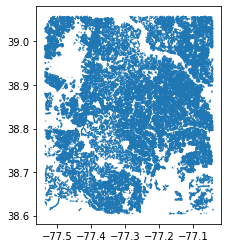

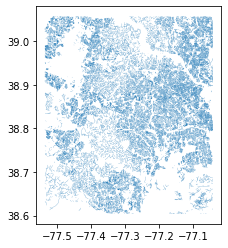

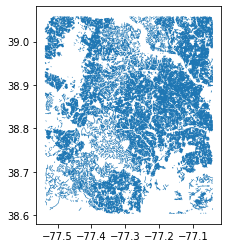

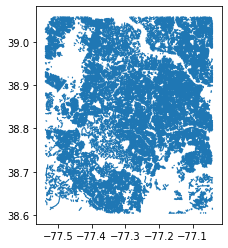

In [86]:
roads_cat1.plot()
buffered_cat1_30.plot()
buffered_cat1_60.plot()
buffered_cat1_90.plot()

<AxesSubplot:>

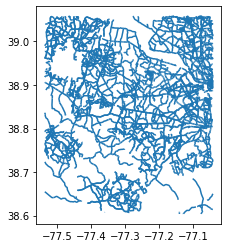

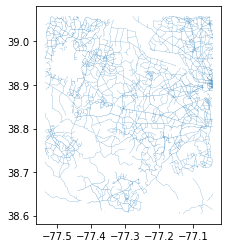

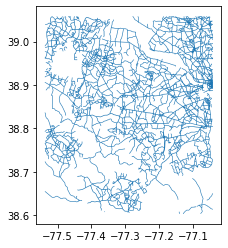

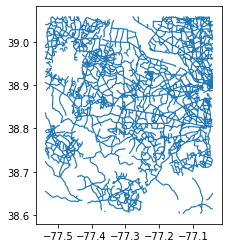

In [87]:
roads_cat2.plot()
buffered_cat2_30.plot()
buffered_cat2_60.plot()
buffered_cat2_90.plot()

<AxesSubplot:>

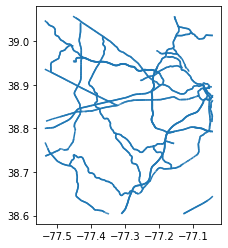

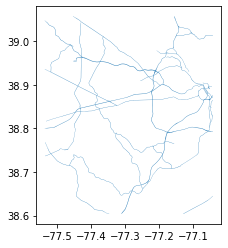

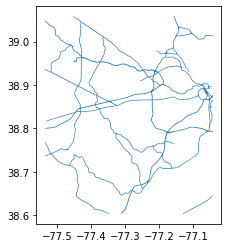

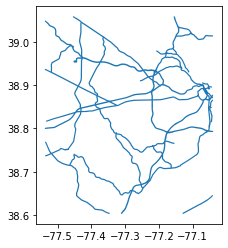

In [88]:
roads_cat3.plot()
buffered_cat3_30.plot()
buffered_cat3_60.plot()
buffered_cat3_90.plot()

<AxesSubplot:>

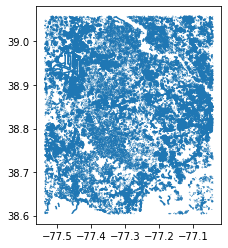

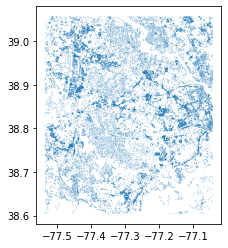

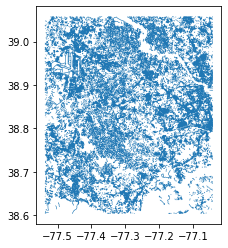

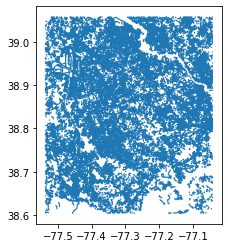

In [89]:
roads_cat4.plot()
buffered_cat4_30.plot()
buffered_cat4_60.plot()
buffered_cat4_90.plot()

In [90]:
def join_buildings(buffer_category, roads_category):
    buffered_category = {
        'cat1_30': buffered_cat1_30,
        'cat1_60': buffered_cat1_60,
        'cat1_90': buffered_cat1_90,
        'cat2_30': buffered_cat2_30,
        'cat2_60': buffered_cat2_60,
        'cat2_90': buffered_cat2_90,
        'cat3_30': buffered_cat3_30,
        'cat3_60': buffered_cat3_60,
        'cat3_90': buffered_cat3_90,
        'cat4_30': buffered_cat4_30,
        'cat4_60': buffered_cat4_60,
        'cat4_90': buffered_cat4_90,

    }.get(buffer_category)

    joined = buildings_gdf.sjoin(buffered_category, how='left')
    #joined = buildings_gdf.sjoin(buffered_category, how="left", predicate='intersects')
    joined.rename(columns={'index_right': 'index_roads'}, inplace=True)
    #joined.drop_duplicates(subset='id_left',inplace=True)
    if roads_category:
        joined['buffered_highway'] = \
            joined['buffered_highway'].apply(lambda x: 'not_residential' if pd.isnull(x) else x)
    else:
        joined['buffered_highway'] = \
            joined['buffered_highway'].apply(lambda x: 'residential' if pd.isnull(x) else x)

    joined.reset_index(inplace=True, drop=True)
    
    return joined

In [91]:
buffer_categories = ['cat1_30', 'cat1_60', 'cat1_90','cat2_30','cat2_60','cat2_90',\
                    'cat3_30', 'cat3_60', 'cat3_90','cat4_30','cat4_60','cat4_90']
roads_category = 1                      # 1 is residential, 0 is ['primary', 'secondary','tertiary']
joined_buildings1 = join_buildings(buffer_categories[0],roads_category)
joined_buildings2 = join_buildings(buffer_categories[1],roads_category)
joined_buildings3 = join_buildings(buffer_categories[2],roads_category)
roads_category = 0
joined_buildings4 = join_buildings(buffer_categories[3],roads_category)
joined_buildings5 = join_buildings(buffer_categories[4],roads_category)
joined_buildings6 = join_buildings(buffer_categories[5],roads_category)
joined_buildings7 = join_buildings(buffer_categories[6],roads_category)
joined_buildings8 = join_buildings(buffer_categories[7],roads_category)
joined_buildings9 = join_buildings(buffer_categories[8],roads_category)
joined_buildings10 = join_buildings(buffer_categories[9],roads_category)
joined_buildings11 = join_buildings(buffer_categories[10],roads_category)
joined_buildings12 = join_buildings(buffer_categories[11],roads_category)

In [92]:
print(joined_buildings1.shape)
print(joined_buildings2.shape)
print(joined_buildings3.shape)
print(joined_buildings4.shape)
print(joined_buildings5.shape)
print(joined_buildings6.shape)
print(joined_buildings7.shape)
print(joined_buildings8.shape)
print(joined_buildings9.shape)
print(joined_buildings10.shape)
print(joined_buildings11.shape)
print(joined_buildings12.shape)

(204672, 14)
(204672, 14)
(204672, 14)
(204672, 14)
(204672, 14)
(204672, 14)
(204672, 14)
(204672, 14)
(204672, 14)
(204672, 14)
(204672, 14)
(204672, 14)


In [93]:
joined_buildings1.groupby('official_type').count()

,id_left,building,geometry,all_tag_keys,all_tags,index_landuse,landuse,land_building,index_official,OBJECTID,index_roads,id_right,buffered_highway
official_type,,,,,,,,,,,,,
NON_RES,10182,10182,10182,10182,10182,4161,10182,10182,10182,10182,2466,2466,10182
RES,194490,194490,194490,194490,194490,41346,194490,194490,194490,194490,146277,146277,194490


In [94]:
joined_buildings1.groupby(['official_type','buffered_highway']).count()

id_left  building  geometry  all_tag_keys  \
official_type buffered_highway                                              
NON_RES       not_residential      7716      7716      7716          7716   
              residential          2466      2466      2466          2466   
RES           not_residential     48213     48213     48213         48213   
              residential        146277    146277    146277        146277   

                                all_tags  index_landuse  landuse  \
official_type buffered_highway                                     
NON_RES       not_residential       7716           2885     7716   
              residential           2466           1276     2466   
RES           not_residential      48213           9165    48213   
              residential         146277          32181   146277   

                                land_building  index_official  OBJECTID  \
official_type buffered_highway                                            
NON_RES       not_residential            7716            7716      7716   
              residential                2466            2466      2466   
RES           not_residential           48213           48213     48213   
              residential              146277          146277    146277   

                                index_roads  id_right  
official_type buffered_highway                         
NON_RES       not_residential             0         0  
              residential              2466      2466  
RES           not_residential             0         0  
              residential            146277    146277

In [95]:
joined_buildings1[(joined_buildings1['land_building'] == 'commercial')\
               &(joined_buildings1['buffered_highway'] == 'residential')].shape

(143, 14)

In [96]:
joined_buildings2.groupby(['official_type','buffered_highway']).count()

id_left  building  geometry  all_tag_keys  \
official_type buffered_highway                                              
NON_RES       not_residential      4704      4704      4704          4704   
              residential          5478      5478      5478          5478   
RES           not_residential      6017      6017      6017          6017   
              residential        188473    188473    188473        188473   

                                all_tags  index_landuse  landuse  \
official_type buffered_highway                                     
NON_RES       not_residential       4704           1860     4704   
              residential           5478           2301     5478   
RES           not_residential       6017           1086     6017   
              residential         188473          40260   188473   

                                land_building  index_official  OBJECTID  \
official_type buffered_highway                                            
NON_RES       not_residential            4704            4704      4704   
              residential                5478            5478      5478   
RES           not_residential            6017            6017      6017   
              residential              188473          188473    188473   

                                index_roads  id_right  
official_type buffered_highway                         
NON_RES       not_residential             0         0  
              residential              5478      5478  
RES           not_residential             0         0  
              residential            188473    188473

In [97]:
joined_buildings3.groupby(['official_type','buffered_highway']).count()

id_left  building  geometry  all_tag_keys  \
official_type buffered_highway                                              
NON_RES       not_residential      2695      2695      2695          2695   
              residential          7487      7487      7487          7487   
RES           not_residential      1122      1122      1122          1122   
              residential        193368    193368    193368        193368   

                                all_tags  index_landuse  landuse  \
official_type buffered_highway                                     
NON_RES       not_residential       2695           1137     2695   
              residential           7487           3024     7487   
RES           not_residential       1122            201     1122   
              residential         193368          41145   193368   

                                land_building  index_official  OBJECTID  \
official_type buffered_highway                                            
NON_RES       not_residential            2695            2695      2695   
              residential                7487            7487      7487   
RES           not_residential            1122            1122      1122   
              residential              193368          193368    193368   

                                index_roads  id_right  
official_type buffered_highway                         
NON_RES       not_residential             0         0  
              residential              7487      7487  
RES           not_residential             0         0  
              residential            193368    193368

In [98]:
joined_buildings4.groupby(['official_type','buffered_highway']).count()

id_left  building  geometry  all_tag_keys  \
official_type buffered_highway                                              
NON_RES       non_res_road         1475      1475      1475          1475   
              residential          8707      8707      8707          8707   
RES           non_res_road        13837     13837     13837         13837   
              residential        180653    180653    180653        180653   

                                all_tags  index_landuse  landuse  \
official_type buffered_highway                                     
NON_RES       non_res_road          1475            455     1475   
              residential           8707           3706     8707   
RES           non_res_road         13837           3210    13837   
              residential         180653          38136   180653   

                                land_building  index_official  OBJECTID  \
official_type buffered_highway                                            
NON_RES       non_res_road               1475            1475      1475   
              residential                8707            8707      8707   
RES           non_res_road              13837           13837     13837   
              residential              180653          180653    180653   

                                index_roads  id_right  
official_type buffered_highway                         
NON_RES       non_res_road             1475      1475  
              residential                 0         0  
RES           non_res_road            13837     13837  
              residential                 0         0

In [99]:
joined_buildings5.groupby(['official_type','buffered_highway']).count()

id_left  building  geometry  all_tag_keys  \
official_type buffered_highway                                              
NON_RES       non_res_road         4876      4876      4876          4876   
              residential          5306      5306      5306          5306   
RES           non_res_road        41289     41289     41289         41289   
              residential        153201    153201    153201        153201   

                                all_tags  index_landuse  landuse  \
official_type buffered_highway                                     
NON_RES       non_res_road          4876           1754     4876   
              residential           5306           2407     5306   
RES           non_res_road         41289           9646    41289   
              residential         153201          31700   153201   

                                land_building  index_official  OBJECTID  \
official_type buffered_highway                                            
NON_RES       non_res_road               4876            4876      4876   
              residential                5306            5306      5306   
RES           non_res_road              41289           41289     41289   
              residential              153201          153201    153201   

                                index_roads  id_right  
official_type buffered_highway                         
NON_RES       non_res_road             4876      4876  
              residential                 0         0  
RES           non_res_road            41289     41289  
              residential                 0         0

In [100]:
joined_buildings6.groupby(['official_type','buffered_highway']).count()

id_left  building  geometry  all_tag_keys  \
official_type buffered_highway                                              
NON_RES       non_res_road         6775      6775      6775          6775   
              residential          3407      3407      3407          3407   
RES           non_res_road        77630     77630     77630         77630   
              residential        116860    116860    116860        116860   

                                all_tags  index_landuse  landuse  \
official_type buffered_highway                                     
NON_RES       non_res_road          6775           2634     6775   
              residential           3407           1527     3407   
RES           non_res_road         77630          18223    77630   
              residential         116860          23123   116860   

                                land_building  index_official  OBJECTID  \
official_type buffered_highway                                            
NON_RES       non_res_road               6775            6775      6775   
              residential                3407            3407      3407   
RES           non_res_road              77630           77630     77630   
              residential              116860          116860    116860   

                                index_roads  id_right  
official_type buffered_highway                         
NON_RES       non_res_road             6775      6775  
              residential                 0         0  
RES           non_res_road            77630     77630  
              residential                 0         0

In [101]:
joined_buildings7.groupby(['official_type','buffered_highway']).count()

id_left  building  geometry  all_tag_keys  \
official_type buffered_highway                                              
NON_RES       residential         10005     10005     10005         10005   
              roads_cat3            177       177       177           177   
RES           residential        194308    194308    194308        194308   
              roads_cat3            182       182       182           182   

                                all_tags  index_landuse  landuse  \
official_type buffered_highway                                     
NON_RES       residential          10005           4129    10005   
              roads_cat3             177             32      177   
RES           residential         194308          41308   194308   
              roads_cat3             182             38      182   

                                land_building  index_official  OBJECTID  \
official_type buffered_highway                                            
NON_RES       residential               10005           10005     10005   
              roads_cat3                  177             177       177   
RES           residential              194308          194308    194308   
              roads_cat3                  182             182       182   

                                index_roads  id_right  
official_type buffered_highway                         
NON_RES       residential                 0         0  
              roads_cat3                177       177  
RES           residential                 0         0  
              roads_cat3                182       182

In [102]:
joined_buildings8.groupby(['official_type','buffered_highway']).count()

id_left  building  geometry  all_tag_keys  \
official_type buffered_highway                                              
NON_RES       residential          8798      8798      8798          8798   
              roads_cat3           1384      1384      1384          1384   
RES           residential        190415    190415    190415        190415   
              roads_cat3           4075      4075      4075          4075   

                                all_tags  index_landuse  landuse  \
official_type buffered_highway                                     
NON_RES       residential           8798           3735     8798   
              roads_cat3            1384            426     1384   
RES           residential         190415          40257   190415   
              roads_cat3            4075           1089     4075   

                                land_building  index_official  OBJECTID  \
official_type buffered_highway                                            
NON_RES       residential                8798            8798      8798   
              roads_cat3                 1384            1384      1384   
RES           residential              190415          190415    190415   
              roads_cat3                 4075            4075      4075   

                                index_roads  id_right  
official_type buffered_highway                         
NON_RES       residential                 0         0  
              roads_cat3               1384      1384  
RES           residential                 0         0  
              roads_cat3               4075      4075

In [103]:
joined_buildings9.groupby(['official_type','buffered_highway']).count()

id_left  building  geometry  all_tag_keys  \
official_type buffered_highway                                              
NON_RES       residential          7943      7943      7943          7943   
              roads_cat3           2239      2239      2239          2239   
RES           residential        182748    182748    182748        182748   
              roads_cat3          11742     11742     11742         11742   

                                all_tags  index_landuse  landuse  \
official_type buffered_highway                                     
NON_RES       residential           7943           3423     7943   
              roads_cat3            2239            738     2239   
RES           residential         182748          38291   182748   
              roads_cat3           11742           3055    11742   

                                land_building  index_official  OBJECTID  \
official_type buffered_highway                                            
NON_RES       residential                7943            7943      7943   
              roads_cat3                 2239            2239      2239   
RES           residential              182748          182748    182748   
              roads_cat3                11742           11742     11742   

                                index_roads  id_right  
official_type buffered_highway                         
NON_RES       residential                 0         0  
              roads_cat3               2239      2239  
RES           residential                 0         0  
              roads_cat3              11742     11742

In [104]:
len(areahandler.osm_data)

462512

In [105]:
keys_list = []
for sublist in areahandler.osm_data:
    keys_list.append(sublist[3])

In [106]:
keys_list_flat = [val for sublist in keys_list for val in sublist]

In [107]:
unique_keys = sorted(list(set(keys_list_flat)))

In [108]:
unique_keys

['FIXME',
 'GPS',
 'STATUS',
 'STREET_NAME',
 'STREET_TYPE',
 'SUF_DIR',
 'VEDP:PropertyID',
 'abandoned',
 'access',
 'access:conditional',
 'accessible',
 'addr:city',
 'addr:country',
 'addr:county',
 'addr:district',
 'addr:full',
 'addr:housename',
 'addr:housenumber',
 'addr:housenumber_1',
 'addr:interpolation',
 'addr:last_update',
 'addr:name',
 'addr:place',
 'addr:postcode',
 'addr:province',
 'addr:source',
 'addr:state',
 'addr:street',
 'addr:suburb',
 'addr:suite',
 'addr:unit',
 'addr:zip',
 'aeroway',
 'after_school',
 'age',
 'air_conditioning',
 'alcohol',
 'alt_name',
 'alt_name:en',
 'alt_name:es',
 'alt_name:fr',
 'alt_name:ko',
 'alt_name:nl',
 'alt_name:ru',
 'alt_name_1',
 'alt_name_1:es',
 'alt_name_2',
 'alt_name_3',
 'alt_name_4',
 'amenity',
 'amenity_1',
 'animal_boarding',
 'architect',
 'architect:wikidata',
 'architect:wikipedia',
 'area',
 'atm',
 'attraction',
 'automated',
 'baby_feeding',
 'bar',
 'barrier',
 'bbq',
 'beauty',
 'bench',
 'bicycle',


In [109]:
key_freq = []
for key in unique_keys:
    key_freq.append(keys_list_flat.count(key))
    

In [110]:
len(key_freq)

656

In [111]:
keys_tuples = list(zip(unique_keys, key_freq))
keys_freq_df = pd.DataFrame(keys_tuples, columns = ['Key', 'Freq'])

In [112]:
keys_freq_df.sort_values(by=['Freq'], inplace=True, ascending=False)

In [113]:
keys_freq_df.reset_index(inplace=True, drop=True)

In [114]:
keys_freq_df.head()

,Key,Freq
0,building,462512
1,source,189762
2,addr:street,121669
3,addr:housenumber,118685
4,addr:city,65409


In [115]:
keys_freq_df.sort_values(by=['Key'], inplace=False, ascending=True).head(20)

,Key,Freq
493,FIXME,1
653,GPS,1
49,STATUS,309
35,STREET_NAME,541
34,STREET_TYPE,541
151,SUF_DIR,20
276,VEDP:PropertyID,5
264,abandoned,6
57,access,224
553,access:conditional,1


In [116]:
keys_freq_df.head(21)

,Key,Freq
0,building,462512
1,source,189762
2,addr:street,121669
3,addr:housenumber,118685
4,addr:city,65409
5,addr:postcode,64100
6,addr:state,61223
7,dcgis:captureyear,35141
8,dataset,34741
9,dcgis:gis_id,32099


In [117]:
selected_tags = ['source','addr:street','name','building:levels',\
                'roof:shape','amenity','brand','website','shop']
num_keys = len(selected_tags)+2

In [118]:
len(selected_tags)

9

In [119]:
def preprocess_data(input_data, value_tags, selected_tags):
    col_pos = 2
    for tag_key in selected_tags:
        col_name = tag_key
        input_data.insert(col_pos,col_name,0)
        input_data[col_name] = input_data.apply(lambda x: 1 if tag_key in list(x['all_tag_keys']) \
            else 0, axis=1)

    for tag_key in value_tags:
        input_data[tag_key] = input_data.apply(lambda x: x['all_tags'].get(tag_key) \
            if tag_key in list(x['all_tag_keys']) else 0, axis=1)

    # fix anomalies in FFX County data
    input_data.drop(input_data[(input_data['building:levels'] == 'K-6')].index, inplace=True)
    input_data.loc[(input_data['building:levels'] == '-1,1,2,3'),'building:levels']=4

    input_data.drop(columns=['all_tag_keys', 'all_tags'], inplace=True)

    input_data['official_type'] = \
    input_data['official_type'].apply(lambda x: 1 if x == 'RES' else 0)

    return input_data

In [120]:
def add_buffers(input_data,col_names, buffers_list):
    for num in range(0, len(col_names)):
        input_data.insert(num+2,col_names[num],buffers_list[num])
        input_data[col_names[num]] = input_data[col_names[num]].apply(lambda x: 1 if x == 'residential' else 0)

    return input_data

In [121]:
#num_buffers = 6
#buffer_loc = 0
#value_tags = ['roof:shape','building:levels']
#col_names = ['buffer_cat1_30','buffer_cat1_60','buffer_cat1_90',\
#            'buffer_cat2_30','buffer_cat2_60','buffer_cat2_90']
#buffers_list = [joined_buildings1['buffered_highway'],joined_buildings2['buffered_highway'],\
#                joined_buildings3['buffered_highway'],joined_buildings4['buffered_highway'],\
#                joined_buildings5['buffered_highway'],joined_buildings6['buffered_highway']]

num_buffers = 12
buffer_loc = 0
value_tags = ['roof:shape','building:levels']
col_names = ['buffer_cat1_30','buffer_cat1_60','buffer_cat1_90',\
            'buffer_cat2_30','buffer_cat2_60','buffer_cat2_90',\
            'buffer_cat3_30','buffer_cat3_60','buffer_cat3_90',\
            'buffer_cat4_30','buffer_cat4_60','buffer_cat4_90']
buffers_list = [joined_buildings1['buffered_highway'],joined_buildings2['buffered_highway'],\
                joined_buildings3['buffered_highway'],joined_buildings4['buffered_highway'],\
                joined_buildings5['buffered_highway'],joined_buildings6['buffered_highway'],\
                joined_buildings7['buffered_highway'],joined_buildings8['buffered_highway'],\
                joined_buildings9['buffered_highway'],joined_buildings10['buffered_highway'],\
                joined_buildings11['buffered_highway'],joined_buildings12['buffered_highway']]
backup_data = joined_buildings1.copy()
#input_data = input_data[['geometry','official_type','land_building','all_tag_keys','all_tags']]
#input_data = input_data[['geometry','official_type','building','landuse','all_tag_keys','all_tags']]
#input_data = input_data[['geometry','official_type','building','landuse',\
#                        'all_tag_keys','all_tags','id_left']]
#input_data = input_data[['geometry','official_type','building','landuse','amenity_key','parking_area',\
#                        'all_tag_keys','all_tags']]
backup_data = backup_data[['geometry','official_type','building','landuse','land_building',\
                        'all_tag_keys','all_tags','id_left']]
backup_data.insert(len(backup_data.columns), 'area',backup_data['geometry'].to_crs(epsg=32610).area)
backup_data = preprocess_data(backup_data,value_tags,selected_tags)

backup_data = add_buffers(backup_data,col_names[buffer_loc:buffer_loc+num_buffers],\
                         buffers_list[buffer_loc:buffer_loc+num_buffers])

In [122]:
len(areahandler.amenity_data)

17552

In [123]:
# transform the list of roads into a pandas DataFrame
amenity_colnames = ['amenity_key', 'geometry']
amenity_df = pd.DataFrame(areahandler.amenity_data, columns=amenity_colnames)

In [124]:
amenity_df.head()

,amenity_key,geometry
0,parking,"POLYGON ((-77.286224 38.8084854, -77.2862075 3..."
1,parking,"POLYGON ((-77.5252903 38.8192251, -77.5252653 ..."
2,parking,"POLYGON ((-77.0565916 38.8770739, -77.055968 3..."
3,parking,"POLYGON ((-77.0676698 38.8976966, -77.0674961 ..."
4,place_of_worship,"POLYGON ((-77.108128 38.8682955, -77.1077849 3..."


In [125]:
amenity_df.shape

(17552, 2)

In [126]:
amenity_categories = amenity_df.groupby(['amenity_key'])['geometry'].count().reset_index(name="count")

In [127]:
amenity_categories.tail(50)

,amenity_key,count
47,library,62
48,marketplace,7
49,monastery,1
50,mortuary,1
51,motorcycle_parking,4
52,music_school,2
53,nightclub,1
54,nursing_home,7
55,office,1
56,parking,11561


In [128]:
parking_df = amenity_df[(amenity_df['amenity_key'] == 'parking') | (amenity_df['amenity_key'] == 'parking_space')]

In [129]:
parking_df = parking_df.assign(amenity_key='parking')

In [130]:
parking_df.reset_index(inplace=True, drop=True)

In [131]:
parking_df.shape

(13296, 2)

In [132]:
parking_gdf = geopandas.GeoDataFrame(parking_df.copy(),crs="EPSG:4326",geometry='geometry')

In [133]:
parking_gdf.insert(len(parking_gdf.columns), 'parking_area',parking_gdf['geometry'].to_crs(epsg=32610).area)

In [134]:
parking_gdf.head()

,amenity_key,geometry,parking_area
0,parking,"POLYGON ((-77.28622 38.80849, -77.28621 38.808...",1184.748131
1,parking,"POLYGON ((-77.52529 38.81923, -77.52527 38.819...",1840.915894
2,parking,"POLYGON ((-77.05659 38.87707, -77.05597 38.876...",114562.201578
3,parking,"POLYGON ((-77.06767 38.89770, -77.06750 38.897...",6137.730716
4,parking,"POLYGON ((-77.08700 38.80838, -77.08667 38.808...",30555.378953


In [135]:
parking_gdf.shape

(13296, 3)

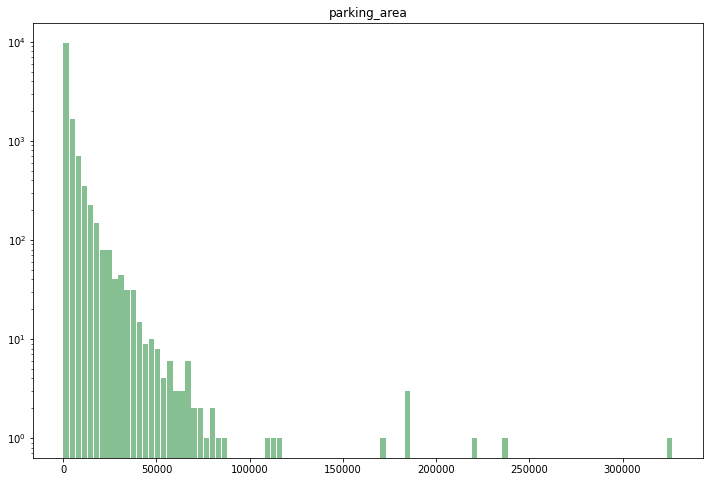

In [136]:
hist = parking_gdf.hist(bins=100, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)
plt.yscale('log')

In [138]:
breaks = jenkspy.jenks_breaks(parking_gdf['parking_area'], n_classes=3)
print(breaks)

[8.462519956797522, 13218.79437633815, 87875.54005280347, 326822.4238321826]


In [139]:
bins_list = ['bin1','bin2','bin3']
parking_gdf['cut_jenks'] = pd.cut(parking_gdf['parking_area'],
                                bins=breaks,
                                labels=bins_list,
                                include_lowest=True)

In [140]:
parking_gdf.head()

,amenity_key,geometry,parking_area,cut_jenks
0,parking,"POLYGON ((-77.28622 38.80849, -77.28621 38.808...",1184.748131,bin1
1,parking,"POLYGON ((-77.52529 38.81923, -77.52527 38.819...",1840.915894,bin1
2,parking,"POLYGON ((-77.05659 38.87707, -77.05597 38.876...",114562.201578,bin3
3,parking,"POLYGON ((-77.06767 38.89770, -77.06750 38.897...",6137.730716,bin1
4,parking,"POLYGON ((-77.08700 38.80838, -77.08667 38.808...",30555.378953,bin2


In [141]:
for bin in bins_list:
    parking_gdf.insert(len(parking_gdf.columns),bin,0)
    parking_gdf[bin] = parking_gdf.apply(lambda x: 1 if x['cut_jenks'] == bin\
                                     else 0, axis=1)

In [142]:
parking_gdf.head()

,amenity_key,geometry,parking_area,cut_jenks,bin1,bin2,bin3
0,parking,"POLYGON ((-77.28622 38.80849, -77.28621 38.808...",1184.748131,bin1,1,0,0
1,parking,"POLYGON ((-77.52529 38.81923, -77.52527 38.819...",1840.915894,bin1,1,0,0
2,parking,"POLYGON ((-77.05659 38.87707, -77.05597 38.876...",114562.201578,bin3,0,0,1
3,parking,"POLYGON ((-77.06767 38.89770, -77.06750 38.897...",6137.730716,bin1,1,0,0
4,parking,"POLYGON ((-77.08700 38.80838, -77.08667 38.808...",30555.378953,bin2,0,1,0


In [143]:
backup_data.columns

Index(['geometry', 'official_type', 'buffer_cat1_30', 'buffer_cat1_60',
       'buffer_cat1_90', 'buffer_cat2_30', 'buffer_cat2_60', 'buffer_cat2_90',
       'buffer_cat3_30', 'buffer_cat3_60', 'buffer_cat3_90', 'buffer_cat4_30',
       'buffer_cat4_60', 'buffer_cat4_90', 'shop', 'website', 'brand',
       'amenity', 'roof:shape', 'building:levels', 'name', 'addr:street',
       'source', 'building', 'landuse', 'land_building', 'id_left', 'area'],
      dtype='object')

In [144]:
radius_list = [30,60,90]
counter = 1
for bin in bins_list:
    for radius in radius_list:
        parking_buffer = parking_gdf.copy()
        parking_buffer = parking_buffer[['geometry',bin]]
        col_name = 'parking_cat'+str(counter)
        counter += 1
        parking_buffer.rename(columns={bin: col_name}, inplace=True)
        parking_buffer['geometry'] = parking_buffer['geometry'].to_crs(epsg=32610).buffer(radius)
        parking_buffer.to_crs(epsg=4326, inplace=True)
        buildings_parking = backup_data.sjoin(parking_buffer, how="left", predicate='intersects')
        buildings_parking[col_name] = buildings_parking[col_name].fillna(0)
        buildings_parking.drop_duplicates(subset='id_left',inplace=True)
        buildings_parking.reset_index(inplace=True, drop=True)
        backup_data.insert(len(backup_data.columns),col_name,list(buildings_parking[col_name]))

In [145]:
backup_data.drop(columns=['id_left'], inplace=True)

In [146]:
backup_data.shape

(204671, 36)

In [147]:
backup_data.head()

,geometry,official_type,buffer_cat1_30,buffer_cat1_60,buffer_cat1_90,buffer_cat2_30,buffer_cat2_60,buffer_cat2_90,buffer_cat3_30,buffer_cat3_60,...,area,parking_cat1,parking_cat2,parking_cat3,parking_cat4,parking_cat5,parking_cat6,parking_cat7,parking_cat8,parking_cat9
0,"POLYGON ((-77.45006 38.95307, -77.45006 38.953...",0,0,0,0,1,1,1,0,0,...,42356.626389,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"POLYGON ((-77.45205 38.95196, -77.45125 38.951...",0,0,0,0,1,1,1,0,0,...,24577.466543,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"POLYGON ((-77.44745 38.95194, -77.44745 38.951...",0,0,0,0,1,1,1,1,1,...,3065.840442,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"POLYGON ((-77.44833 38.95147, -77.44801 38.951...",0,0,0,0,1,1,1,1,1,...,6191.860154,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"POLYGON ((-77.45001 38.95145, -77.44989 38.951...",0,0,0,0,1,1,1,1,1,...,1073.451378,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [148]:
# content_FFX = os.listdir("/DATA2/dse313/group15/FFX/")

if "FFX_Backup_Data" not in os.listdir("/DATA2/dse313/group15/FFX/"):
    os.mkdir("/DATA2/dse313/group15/FFX/FFX_Backup_Data/")

backup_data.to_pickle("/DATA2/dse313/group15/FFX/FFX_Backup_Data/FFX.pkl") 

In [3]:
backup_data = pd.read_pickle("/DATA2/dse313/group15/FFX/FFX_Backup_Data/FFX.pkl")

In [4]:
input_data = backup_data.copy()

In [5]:
input_data.columns

Index(['geometry', 'official_type', 'buffer_cat1_30', 'buffer_cat1_60',
       'buffer_cat1_90', 'buffer_cat2_30', 'buffer_cat2_60', 'buffer_cat2_90',
       'buffer_cat3_30', 'buffer_cat3_60', 'buffer_cat3_90', 'buffer_cat4_30',
       'buffer_cat4_60', 'buffer_cat4_90', 'shop', 'website', 'brand',
       'amenity', 'roof:shape', 'building:levels', 'name', 'addr:street',
       'source', 'building', 'landuse', 'land_building', 'area',
       'parking_cat1', 'parking_cat2', 'parking_cat3', 'parking_cat4',
       'parking_cat5', 'parking_cat6', 'parking_cat7', 'parking_cat8',
       'parking_cat9'],
      dtype='object')

In [6]:
#input_data.drop(columns=['buffer_cat1_30', 'buffer_cat1_60',\
#                        'buffer_cat1_90', 'buffer_cat2_30', 'buffer_cat2_60', 'buffer_cat2_90',\
#                        'buffer_cat3_30', 'buffer_cat3_60', 'buffer_cat3_90', 'buffer_cat4_30',\
#                        'buffer_cat4_60', 'buffer_cat4_90',\
#                        \
#                        'land_building',\
#                        'parking_cat1', 'parking_cat2', 'parking_cat3', 'parking_cat4',\
#                        'parking_cat5', 'parking_cat6', 'parking_cat7', 'parking_cat8',\
#                        'parking_cat9'], inplace=True)

In [7]:
input_data.drop(columns=['land_building', 'roof:shape'], inplace=True)

In [8]:
input_data.columns

Index(['geometry', 'official_type', 'buffer_cat1_30', 'buffer_cat1_60',
       'buffer_cat1_90', 'buffer_cat2_30', 'buffer_cat2_60', 'buffer_cat2_90',
       'buffer_cat3_30', 'buffer_cat3_60', 'buffer_cat3_90', 'buffer_cat4_30',
       'buffer_cat4_60', 'buffer_cat4_90', 'shop', 'website', 'brand',
       'amenity', 'building:levels', 'name', 'addr:street', 'source',
       'building', 'landuse', 'area', 'parking_cat1', 'parking_cat2',
       'parking_cat3', 'parking_cat4', 'parking_cat5', 'parking_cat6',
       'parking_cat7', 'parking_cat8', 'parking_cat9'],
      dtype='object')

In [9]:
input_data.shape

(204671, 34)

In [10]:
input_data.groupby('landuse').count().sort_values(by=['geometry'], inplace=False, ascending=False).head(50)

,geometry,official_type,buffer_cat1_30,buffer_cat1_60,buffer_cat1_90,buffer_cat2_30,buffer_cat2_60,buffer_cat2_90,buffer_cat3_30,buffer_cat3_60,...,area,parking_cat1,parking_cat2,parking_cat3,parking_cat4,parking_cat5,parking_cat6,parking_cat7,parking_cat8,parking_cat9
landuse,,,,,,,,,,,,,,,,,,,,,
no_landuse,159165,159165,159165,159165,159165,159165,159165,159165,159165,159165,...,159165,159165,159165,159165,159165,159165,159165,159165,159165,159165
residential,41535,41535,41535,41535,41535,41535,41535,41535,41535,41535,...,41535,41535,41535,41535,41535,41535,41535,41535,41535,41535
non_res,2500,2500,2500,2500,2500,2500,2500,2500,2500,2500,...,2500,2500,2500,2500,2500,2500,2500,2500,2500,2500
military,1333,1333,1333,1333,1333,1333,1333,1333,1333,1333,...,1333,1333,1333,1333,1333,1333,1333,1333,1333,1333
construction,38,38,38,38,38,38,38,38,38,38,...,38,38,38,38,38,38,38,38,38,38
forest,23,23,23,23,23,23,23,23,23,23,...,23,23,23,23,23,23,23,23,23,23
recreation_ground,19,19,19,19,19,19,19,19,19,19,...,19,19,19,19,19,19,19,19,19,19
farmland,17,17,17,17,17,17,17,17,17,17,...,17,17,17,17,17,17,17,17,17,17
cemetery,16,16,16,16,16,16,16,16,16,16,...,16,16,16,16,16,16,16,16,16,16


In [11]:
input_data.groupby('building').count().sort_values(by=['geometry'], inplace=False, ascending=False).head(50)

,geometry,official_type,buffer_cat1_30,buffer_cat1_60,buffer_cat1_90,buffer_cat2_30,buffer_cat2_60,buffer_cat2_90,buffer_cat3_30,buffer_cat3_60,...,area,parking_cat1,parking_cat2,parking_cat3,parking_cat4,parking_cat5,parking_cat6,parking_cat7,parking_cat8,parking_cat9
building,,,,,,,,,,,,,,,,,,,,,
yes,164163,164163,164163,164163,164163,164163,164163,164163,164163,164163,...,164163,164163,164163,164163,164163,164163,164163,164163,164163,164163
house,20169,20169,20169,20169,20169,20169,20169,20169,20169,20169,...,20169,20169,20169,20169,20169,20169,20169,20169,20169,20169
detached,8565,8565,8565,8565,8565,8565,8565,8565,8565,8565,...,8565,8565,8565,8565,8565,8565,8565,8565,8565,8565
residential,3210,3210,3210,3210,3210,3210,3210,3210,3210,3210,...,3210,3210,3210,3210,3210,3210,3210,3210,3210,3210
terrace,3045,3045,3045,3045,3045,3045,3045,3045,3045,3045,...,3045,3045,3045,3045,3045,3045,3045,3045,3045,3045
apartments,1408,1408,1408,1408,1408,1408,1408,1408,1408,1408,...,1408,1408,1408,1408,1408,1408,1408,1408,1408,1408
retail,692,692,692,692,692,692,692,692,692,692,...,692,692,692,692,692,692,692,692,692,692
commercial,576,576,576,576,576,576,576,576,576,576,...,576,576,576,576,576,576,576,576,576,576
garage,443,443,443,443,443,443,443,443,443,443,...,443,443,443,443,443,443,443,443,443,443


In [12]:
input_data['building'].unique()

array(['airport_terminal', 'yes', 'office', 'retail', 'no', 'school',
       'industrial', 'commercial', 'roof', 'hangar', 'museum',
       'apartments', 'garage', 'residential', 'parking', 'house',
       'train_station', 'warehouse', 'hospital', 'canopy', 'church',
       'data_center', 'kindergarten', 'terrace', 'boathouse', 'service',
       'detached', 'attached', 'public', 'supermarket', 'barn',
       'pavilion', 'sports_centre', 'mosque', 'gazebo', 'hotel',
       'fire_station', 'central_office', 'grandstand', 'bunker',
       'government', 'office;yes', 'shed', 'college', 'construction',
       'chapel', 'civic', 'transportation', 'bridge', 'storage',
       'semidetached_house', 'garages', 'greenhouse', 'manufacture',
       'commecial', 'turning_circle', 'q', 'dormitory', 'townhome',
       'Pumping_Station', 'townhouse', 'Townhouse', 'prison',
       'foundation', 'cabin', 'static_caravan', 'religious'], dtype=object)

In [13]:
common_buildings = np.array(['apartments', 'church', 'civic', 'commercial', 'construction',
       'detached', 'dormitory', 'garage', 'garages', 'greenhouse',
       'hospital', 'hotel', 'house', 'industrial', 'kindergarten',
       'office', 'parking', 'public', 'residential', 'retail', 'roof',
       'school', 'semidetached_house', 'service', 'shed',
       'static_caravan', 'terrace', 'warehouse', 'yes'], dtype=object)

In [14]:
unique_buildings = np.setxor1d(input_data['building'].unique(), common_buildings).tolist()

In [15]:
unique_buildings

['Pumping_Station',
 'Townhouse',
 'airport_terminal',
 'attached',
 'barn',
 'boathouse',
 'bridge',
 'bunker',
 'cabin',
 'canopy',
 'central_office',
 'chapel',
 'college',
 'commecial',
 'data_center',
 'fire_station',
 'foundation',
 'gazebo',
 'government',
 'grandstand',
 'hangar',
 'manufacture',
 'mosque',
 'museum',
 'no',
 'office;yes',
 'pavilion',
 'prison',
 'q',
 'religious',
 'sports_centre',
 'storage',
 'supermarket',
 'townhome',
 'townhouse',
 'train_station',
 'transportation',
 'turning_circle']

In [16]:
len(unique_buildings)

38

In [17]:
input_data[input_data['building'].isin(unique_buildings)].shape

(637, 34)

In [18]:
input_data['building'] = input_data['building'].apply(\
                                lambda x: 'misc_buildings' if x in(unique_buildings)
                                                else x)

In [19]:
input_data[input_data['building'].isin(unique_buildings)].shape

(0, 34)

In [20]:
input_data.shape

(204671, 34)

In [21]:
input_data.groupby('building').count().sort_values(by=['geometry'], inplace=False, ascending=False).head(50)

,geometry,official_type,buffer_cat1_30,buffer_cat1_60,buffer_cat1_90,buffer_cat2_30,buffer_cat2_60,buffer_cat2_90,buffer_cat3_30,buffer_cat3_60,...,area,parking_cat1,parking_cat2,parking_cat3,parking_cat4,parking_cat5,parking_cat6,parking_cat7,parking_cat8,parking_cat9
building,,,,,,,,,,,,,,,,,,,,,
yes,164163,164163,164163,164163,164163,164163,164163,164163,164163,164163,...,164163,164163,164163,164163,164163,164163,164163,164163,164163,164163
house,20169,20169,20169,20169,20169,20169,20169,20169,20169,20169,...,20169,20169,20169,20169,20169,20169,20169,20169,20169,20169
detached,8565,8565,8565,8565,8565,8565,8565,8565,8565,8565,...,8565,8565,8565,8565,8565,8565,8565,8565,8565,8565
residential,3210,3210,3210,3210,3210,3210,3210,3210,3210,3210,...,3210,3210,3210,3210,3210,3210,3210,3210,3210,3210
terrace,3045,3045,3045,3045,3045,3045,3045,3045,3045,3045,...,3045,3045,3045,3045,3045,3045,3045,3045,3045,3045
apartments,1408,1408,1408,1408,1408,1408,1408,1408,1408,1408,...,1408,1408,1408,1408,1408,1408,1408,1408,1408,1408
retail,692,692,692,692,692,692,692,692,692,692,...,692,692,692,692,692,692,692,692,692,692
misc_buildings,637,637,637,637,637,637,637,637,637,637,...,637,637,637,637,637,637,637,637,637,637
commercial,576,576,576,576,576,576,576,576,576,576,...,576,576,576,576,576,576,576,576,576,576


In [22]:
common_landuse = np.array(['non_res', 'no_landuse', 'residential', 'construction',
       'forest', 'recreation_ground', 'cemetery', 'farmyard'], dtype=object)

In [23]:
unique_landuse = np.setxor1d(input_data['landuse'].unique(), common_landuse).tolist()

In [24]:
unique_landuse

['depot',
 'farmland',
 'flowerbed',
 'military',
 'religious',
 'training',
 'vineyard']

In [25]:
input_data[input_data['landuse'].isin(unique_landuse)].shape

(1366, 34)

In [26]:
input_data['landuse'] = input_data['landuse'].apply(\
                                lambda x: 'misc_landuse' if x in(unique_landuse)
                                                else x)

In [27]:
input_data[input_data['landuse'].isin(unique_landuse)].shape

(0, 34)

In [28]:
input_data.groupby('landuse').count().sort_values(by=['geometry'], inplace=False, ascending=False).head(50)

,geometry,official_type,buffer_cat1_30,buffer_cat1_60,buffer_cat1_90,buffer_cat2_30,buffer_cat2_60,buffer_cat2_90,buffer_cat3_30,buffer_cat3_60,...,area,parking_cat1,parking_cat2,parking_cat3,parking_cat4,parking_cat5,parking_cat6,parking_cat7,parking_cat8,parking_cat9
landuse,,,,,,,,,,,,,,,,,,,,,
no_landuse,159165,159165,159165,159165,159165,159165,159165,159165,159165,159165,...,159165,159165,159165,159165,159165,159165,159165,159165,159165,159165
residential,41535,41535,41535,41535,41535,41535,41535,41535,41535,41535,...,41535,41535,41535,41535,41535,41535,41535,41535,41535,41535
non_res,2500,2500,2500,2500,2500,2500,2500,2500,2500,2500,...,2500,2500,2500,2500,2500,2500,2500,2500,2500,2500
misc_landuse,1366,1366,1366,1366,1366,1366,1366,1366,1366,1366,...,1366,1366,1366,1366,1366,1366,1366,1366,1366,1366
construction,38,38,38,38,38,38,38,38,38,38,...,38,38,38,38,38,38,38,38,38,38
forest,23,23,23,23,23,23,23,23,23,23,...,23,23,23,23,23,23,23,23,23,23
recreation_ground,19,19,19,19,19,19,19,19,19,19,...,19,19,19,19,19,19,19,19,19,19
cemetery,16,16,16,16,16,16,16,16,16,16,...,16,16,16,16,16,16,16,16,16,16
farmyard,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9


In [29]:
input_data['landuse'].replace(['residential','non_res','forest','cemetery','recreation_ground',\
                                'construction','farmyard'],['residential_landuse','non_res_landuse',\
                                'forest_landuse','cemetery_landuse','recreation_ground_landuse',\
                                'construction_landuse','farmyard_landuse'], inplace=True)

In [30]:
input_data.groupby('landuse').count().sort_values(by=['geometry'], inplace=False, ascending=False).head(50)

,geometry,official_type,buffer_cat1_30,buffer_cat1_60,buffer_cat1_90,buffer_cat2_30,buffer_cat2_60,buffer_cat2_90,buffer_cat3_30,buffer_cat3_60,...,area,parking_cat1,parking_cat2,parking_cat3,parking_cat4,parking_cat5,parking_cat6,parking_cat7,parking_cat8,parking_cat9
landuse,,,,,,,,,,,,,,,,,,,,,
no_landuse,159165,159165,159165,159165,159165,159165,159165,159165,159165,159165,...,159165,159165,159165,159165,159165,159165,159165,159165,159165,159165
residential_landuse,41535,41535,41535,41535,41535,41535,41535,41535,41535,41535,...,41535,41535,41535,41535,41535,41535,41535,41535,41535,41535
non_res_landuse,2500,2500,2500,2500,2500,2500,2500,2500,2500,2500,...,2500,2500,2500,2500,2500,2500,2500,2500,2500,2500
misc_landuse,1366,1366,1366,1366,1366,1366,1366,1366,1366,1366,...,1366,1366,1366,1366,1366,1366,1366,1366,1366,1366
construction_landuse,38,38,38,38,38,38,38,38,38,38,...,38,38,38,38,38,38,38,38,38,38
forest_landuse,23,23,23,23,23,23,23,23,23,23,...,23,23,23,23,23,23,23,23,23,23
recreation_ground_landuse,19,19,19,19,19,19,19,19,19,19,...,19,19,19,19,19,19,19,19,19,19
cemetery_landuse,16,16,16,16,16,16,16,16,16,16,...,16,16,16,16,16,16,16,16,16,16
farmyard_landuse,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9


In [31]:
input_data.shape

(204671, 34)

In [32]:
input_data.columns

Index(['geometry', 'official_type', 'buffer_cat1_30', 'buffer_cat1_60',
       'buffer_cat1_90', 'buffer_cat2_30', 'buffer_cat2_60', 'buffer_cat2_90',
       'buffer_cat3_30', 'buffer_cat3_60', 'buffer_cat3_90', 'buffer_cat4_30',
       'buffer_cat4_60', 'buffer_cat4_90', 'shop', 'website', 'brand',
       'amenity', 'building:levels', 'name', 'addr:street', 'source',
       'building', 'landuse', 'area', 'parking_cat1', 'parking_cat2',
       'parking_cat3', 'parking_cat4', 'parking_cat5', 'parking_cat6',
       'parking_cat7', 'parking_cat8', 'parking_cat9'],
      dtype='object')

In [33]:
FFX_baseline = input_data.copy()

In [34]:
FFX_baseline.columns

Index(['geometry', 'official_type', 'buffer_cat1_30', 'buffer_cat1_60',
       'buffer_cat1_90', 'buffer_cat2_30', 'buffer_cat2_60', 'buffer_cat2_90',
       'buffer_cat3_30', 'buffer_cat3_60', 'buffer_cat3_90', 'buffer_cat4_30',
       'buffer_cat4_60', 'buffer_cat4_90', 'shop', 'website', 'brand',
       'amenity', 'building:levels', 'name', 'addr:street', 'source',
       'building', 'landuse', 'area', 'parking_cat1', 'parking_cat2',
       'parking_cat3', 'parking_cat4', 'parking_cat5', 'parking_cat6',
       'parking_cat7', 'parking_cat8', 'parking_cat9'],
      dtype='object')

In [35]:
FFX_baseline = FFX_baseline[['geometry', 'official_type', 'building']]

In [36]:
FFX_baseline.columns

Index(['geometry', 'official_type', 'building'], dtype='object')

In [37]:
FFX_baseline.head()

,geometry,official_type,building
0,"POLYGON ((-77.45006 38.95307, -77.45006 38.953...",0,misc_buildings
1,"POLYGON ((-77.45205 38.95196, -77.45125 38.951...",0,misc_buildings
2,"POLYGON ((-77.44745 38.95194, -77.44745 38.951...",0,misc_buildings
3,"POLYGON ((-77.44833 38.95147, -77.44801 38.951...",0,yes
4,"POLYGON ((-77.45001 38.95145, -77.44989 38.951...",0,yes


In [38]:
residential_list = ['residential','apartments','dormitory', 'house','semidetached_house']
FFX_baseline['building'] = FFX_baseline['building'].apply(\
                                lambda x: 'residential' if x in(residential_list)
                                                else x)

In [39]:
non_residential_list = ['public','commercial','industrial', 'school','church','office',
                        'retail','hotel','warehouse','kindergarten','civic','hospital']
FFX_baseline['building'] = FFX_baseline['building'].apply(\
                                lambda x: 'non_residential' if x in(non_residential_list)
                                                else x)

In [40]:
unknown_list = ['yes','detached','terrace', 'garage','roof','shed',
                'parking','garages','greenhouse','static_caravan','service','construction',
                'misc_buildings']
FFX_baseline['building'] = FFX_baseline['building'].apply(\
                                lambda x: 'unknown' if x in(unknown_list)
                                                else x)

In [41]:
FFX_baseline.head()

,geometry,official_type,building
0,"POLYGON ((-77.45006 38.95307, -77.45006 38.953...",0,unknown
1,"POLYGON ((-77.45205 38.95196, -77.45125 38.951...",0,unknown
2,"POLYGON ((-77.44745 38.95194, -77.44745 38.951...",0,unknown
3,"POLYGON ((-77.44833 38.95147, -77.44801 38.951...",0,unknown
4,"POLYGON ((-77.45001 38.95145, -77.44989 38.951...",0,unknown


In [42]:
FFX_baseline.groupby('building').count()

,geometry,official_type
building,,
non_residential,2040,2040
residential,25129,25129
unknown,177502,177502


In [43]:
FFX_baseline.groupby(['official_type','building']).count()

geometry
official_type building                 
0             non_residential      1961
              residential           140
              unknown              8080
1             non_residential        79
              residential         24989
              unknown            169422

In [44]:
if "FFX_Baseline" not in os.listdir("/DATA2/dse313/group15/FFX/"):
    os.mkdir("/DATA2/dse313/group15/FFX/FFX_Baseline/")

FFX_baseline.to_file("/DATA2/dse313/group15/FFX/FFX_Baseline/FFX_Baseline.shp")

<ipython-input-44-228f0509e75f>:4: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  FFX_baseline.to_file("/DATA2/dse313/group15/FFX/FFX_Baseline/FFX_Baseline.shp")


In [45]:
FFX_baseline.groupby('official_type').count()

,geometry,building
official_type,,
0,10181,10181
1,194490,194490


In [46]:
#output_filtered.to_file("./Datasets/OSM/Geopandas_Output/filtered_output.shp")
#input_data.to_file("./Datasets/OSM/Geopandas_Output/input_data.shp")

In [47]:
def nominal_transform(input_data, value_tags):
    ohe = preprocessing.OneHotEncoder(sparse = False)
    for tag in value_tags:
        ohe_results = ohe.fit_transform(input_data[[tag]])
        input_data.reset_index(inplace=True, drop=True)
        input_data = pd.concat([input_data, \
            pd.DataFrame(ohe_results, columns=ohe.categories_[0].tolist())], axis=1)
        input_data.drop(columns=[tag], inplace=True)
        
    return input_data

In [48]:
# nominal transform

#value_tags = ['roof:shape','building','landuse']
#value_tags = ['roof:shape','land_building']
#value_tags = ['roof:shape','building']
value_tags = ['building','landuse']
nominal_data = input_data.copy()
#nominal_data['roof:shape'] = nominal_data['roof:shape'].astype(str)
nominal_data = nominal_transform(nominal_data, value_tags)
nominal_features = list(nominal_data.columns[2:])
nominal_features

/home/dse313/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/dse313/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


['buffer_cat1_30',
 'buffer_cat1_60',
 'buffer_cat1_90',
 'buffer_cat2_30',
 'buffer_cat2_60',
 'buffer_cat2_90',
 'buffer_cat3_30',
 'buffer_cat3_60',
 'buffer_cat3_90',
 'buffer_cat4_30',
 'buffer_cat4_60',
 'buffer_cat4_90',
 'shop',
 'website',
 'brand',
 'amenity',
 'building:levels',
 'name',
 'addr:street',
 'source',
 'area',
 'parking_cat1',
 'parking_cat2',
 'parking_cat3',
 'parking_cat4',
 'parking_cat5',
 'parking_cat6',
 'parking_cat7',
 'parking_cat8',
 'parking_cat9',
 'apartments',
 'church',
 'civic',
 'commercial',
 'construction',
 'detached',
 'dormitory',
 'garage',
 'garages',
 'greenhouse',
 'hospital',
 'hotel',
 'house',
 'industrial',
 'kindergarten',
 'misc_buildings',
 'office',
 'parking',
 'public',
 'residential',
 'retail',
 'roof',
 'school',
 'semidetached_house',
 'service',
 'shed',
 'static_caravan',
 'terrace',
 'warehouse',
 'yes',
 'cemetery_landuse',
 'construction_landuse',
 'farmyard_landuse',
 'forest_landuse',
 'misc_landuse',
 'no_landuse'

In [49]:
nominal_data.columns

Index(['geometry', 'official_type', 'buffer_cat1_30', 'buffer_cat1_60',
       'buffer_cat1_90', 'buffer_cat2_30', 'buffer_cat2_60', 'buffer_cat2_90',
       'buffer_cat3_30', 'buffer_cat3_60', 'buffer_cat3_90', 'buffer_cat4_30',
       'buffer_cat4_60', 'buffer_cat4_90', 'shop', 'website', 'brand',
       'amenity', 'building:levels', 'name', 'addr:street', 'source', 'area',
       'parking_cat1', 'parking_cat2', 'parking_cat3', 'parking_cat4',
       'parking_cat5', 'parking_cat6', 'parking_cat7', 'parking_cat8',
       'parking_cat9', 'apartments', 'church', 'civic', 'commercial',
       'construction', 'detached', 'dormitory', 'garage', 'garages',
       'greenhouse', 'hospital', 'hotel', 'house', 'industrial',
       'kindergarten', 'misc_buildings', 'office', 'parking', 'public',
       'residential', 'retail', 'roof', 'school', 'semidetached_house',
       'service', 'shed', 'static_caravan', 'terrace', 'warehouse', 'yes',
       'cemetery_landuse', 'construction_landuse', 'farm

In [50]:
sorted(nominal_data.columns)

['addr:street',
 'amenity',
 'apartments',
 'area',
 'brand',
 'buffer_cat1_30',
 'buffer_cat1_60',
 'buffer_cat1_90',
 'buffer_cat2_30',
 'buffer_cat2_60',
 'buffer_cat2_90',
 'buffer_cat3_30',
 'buffer_cat3_60',
 'buffer_cat3_90',
 'buffer_cat4_30',
 'buffer_cat4_60',
 'buffer_cat4_90',
 'building:levels',
 'cemetery_landuse',
 'church',
 'civic',
 'commercial',
 'construction',
 'construction_landuse',
 'detached',
 'dormitory',
 'farmyard_landuse',
 'forest_landuse',
 'garage',
 'garages',
 'geometry',
 'greenhouse',
 'hospital',
 'hotel',
 'house',
 'industrial',
 'kindergarten',
 'misc_buildings',
 'misc_landuse',
 'name',
 'no_landuse',
 'non_res_landuse',
 'office',
 'official_type',
 'parking',
 'parking_cat1',
 'parking_cat2',
 'parking_cat3',
 'parking_cat4',
 'parking_cat5',
 'parking_cat6',
 'parking_cat7',
 'parking_cat8',
 'parking_cat9',
 'public',
 'recreation_ground_landuse',
 'residential',
 'residential_landuse',
 'retail',
 'roof',
 'school',
 'semidetached_house',

In [51]:
nominal_data.shape

(204671, 71)

In [52]:
nominal_data.head()

,geometry,official_type,buffer_cat1_30,buffer_cat1_60,buffer_cat1_90,buffer_cat2_30,buffer_cat2_60,buffer_cat2_90,buffer_cat3_30,buffer_cat3_60,...,yes,cemetery_landuse,construction_landuse,farmyard_landuse,forest_landuse,misc_landuse,no_landuse,non_res_landuse,recreation_ground_landuse,residential_landuse
0,"POLYGON ((-77.45006 38.95307, -77.45006 38.953...",0,0,0,0,1,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,"POLYGON ((-77.45205 38.95196, -77.45125 38.951...",0,0,0,0,1,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,"POLYGON ((-77.44745 38.95194, -77.44745 38.951...",0,0,0,0,1,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,"POLYGON ((-77.44833 38.95147, -77.44801 38.951...",0,0,0,0,1,1,1,1,1,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,"POLYGON ((-77.45001 38.95145, -77.44989 38.951...",0,0,0,0,1,1,1,1,1,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Confusion matrix:
[[ 1666   415]
 [  290 38564]]


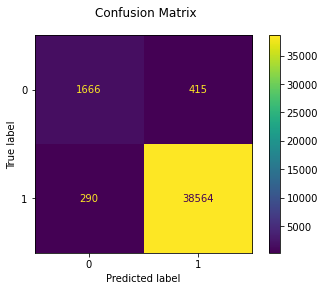

Classification report for classifier DecisionTreeClassifier(class_weight={0: 2.0, 1: 1.0},
                       min_impurity_decrease=0.0001, min_samples_split=20,
                       random_state=0):
              precision    recall  f1-score   support

           0       0.85      0.80      0.83      2081
           1       0.99      0.99      0.99     38854

    accuracy                           0.98     40935
   macro avg       0.92      0.90      0.91     40935
weighted avg       0.98      0.98      0.98     40935




In [53]:
# latest, building and landuse

X = nominal_data[nominal_features]
y = nominal_data["official_type"]
weights = {0:2.0, 1:1.0}

# Split data into 80% train and 20% test subsets
X_train, X_test, y_train, y_test = train_test_split(\
    X, y, test_size=0.2, shuffle=True)
dt_split = DecisionTreeClassifier(class_weight=weights,min_samples_split=20, \
                                random_state=0,min_impurity_decrease = 0.0001)

#dt_split = DecisionTreeClassifier(min_samples_split=20, random_state=0,min_impurity_decrease = 0.0001)

# Learn on the train subset
dt_split.fit(X_train, y_train)

# Predict the target on the test subset
predicted = dt_split.predict(X_test)

# 1 = RES; 0 = NON_RES

disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

print(
    f"Classification report for classifier {dt_split}:\n"
    f"{metrics.classification_report(y_test, predicted)}\n"
)

Confusion matrix:
[[  7994   2187]
 [  3040 191450]]


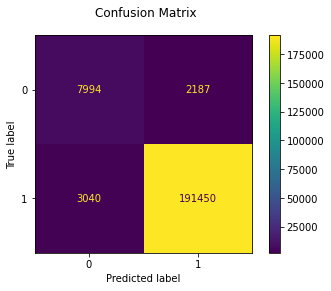

Classification report for classifier DecisionTreeClassifier(class_weight={0: 2.0, 1: 1.0},
                       min_impurity_decrease=0.0001, min_samples_split=20,
                       random_state=0):
              precision    recall  f1-score   support

           0       0.72      0.79      0.75     10181
           1       0.99      0.98      0.99    194490

    accuracy                           0.97    204671
   macro avg       0.86      0.88      0.87    204671
weighted avg       0.98      0.97      0.97    204671




In [54]:
# result for generating output shape file

X = nominal_data[nominal_features]
y = nominal_data["official_type"]
#weights = 'balanced'
weights = {0:2.0, 1:1.0}
dt = DecisionTreeClassifier(class_weight=weights,min_samples_split=20, random_state=0,min_impurity_decrease = 0.0001)
y_pred = cross_val_predict(dt, X, y, cv=10)
disp = metrics.ConfusionMatrixDisplay.from_predictions(y, y_pred)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

print(
    f"Classification report for classifier {dt}:\n"
    f"{metrics.classification_report(y, y_pred)}\n"
)

In [55]:
output_data = nominal_data.copy()
output_data.drop(columns=['official_type','buffer_cat2_30', 'buffer_cat2_60','buffer_cat2_90'], inplace=True)
output_data.insert(1,'official',y)
output_data.insert(2,'predicted',y_pred)
output_filtered = output_data.copy()
#output_filtered = output_filtered[output_filtered['official'] != output_filtered['predicted']]
output_filtered['official'] = \
    output_filtered['official'].apply(lambda x: 'RES' if x == 1 else 'NON_RES')
output_filtered['predicted'] = \
    output_filtered['predicted'].apply(lambda x: 'RES' if x == 1 else 'NON_RES')

In [56]:
#output_filtered.to_file("./Datasets/OSM/Geopandas_Output/filtered_output.shp")

if "FFX_Predictions" not in os.listdir("/DATA2/dse313/group15/FFX/"):
    os.mkdir("/DATA2/dse313/group15/FFX/FFX_Predictions/")
output_data.to_file("/DATA2/dse313/group15/FFX/FFX_Predictions/FFX_Predictions.shp")

<ipython-input-56-561b8d85c9f0>:5: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  output_data.to_file("/DATA2/dse313/group15/FFX/FFX_Predictions/FFX_Predictions.shp")


In [57]:
# # Test on Mecklenburg 20% data

# Mecklenburg_nominal = pd.read_pickle("./Mecklenburg_Processed_Data/Mecklenburg_nominal_data.pkl")

# X = nominal_data[nominal_features]
# y = nominal_data["official_type"]

# Mecklenburg_X = Mecklenburg_nominal[nominal_features]
# Mecklenburg_y = Mecklenburg_nominal["official_type"]

# # Split data into 80% train and 20% test subsets
# X_train, X_test, y_train, y_test = train_test_split(\
#     X, y, test_size=0.2, shuffle=True)

# Mecklenburg_X_train, Mecklenburg_X_test, Mecklenburg_y_train, Mecklenburg_y_test = train_test_split(\
#     Mecklenburg_X, Mecklenburg_y, test_size=0.2, shuffle=True)

# #weights = 'balanced'
# weights = {0:2.0, 1:1.0}
# dt_split = DecisionTreeClassifier(class_weight=weights,min_samples_split=20, \
#                                 random_state=0,min_impurity_decrease = 0.0001)

# #dt_split = DecisionTreeClassifier(min_samples_split=20, random_state=0,min_impurity_decrease = 0.0001)

# # Learn on the train subset
# dt_split.fit(X_train, y_train)

# # Predict the target on the test subset
# predicted = dt_split.predict(Mecklenburg_X_test)

# # 1 = RES; 0 = NON_RES

# disp = metrics.ConfusionMatrixDisplay.from_predictions(Mecklenburg_y_test, predicted)
# disp.figure_.suptitle("Confusion Matrix")
# print(f"Confusion matrix:\n{disp.confusion_matrix}")

# plt.show()

# print(
#     f"Classification report for classifier {dt_split}:\n"
#     f"{metrics.classification_report(Mecklenburg_y_test, predicted)}\n"
# )

In [58]:
# # Test on Mecklenburg 100% data

# Mecklenburg_nominal = pd.read_pickle("./Mecklenburg_Processed_Data/Mecklenburg_nominal_data.pkl")

# X = nominal_data[nominal_features]
# y = nominal_data["official_type"]

# Mecklenburg_X = Mecklenburg_nominal[nominal_features]
# Mecklenburg_y = Mecklenburg_nominal["official_type"]

# #weights = 'balanced'
# weights = {0:2.0, 1:1.0}
# dt_split = DecisionTreeClassifier(class_weight=weights,min_samples_split=20, \
#                                 random_state=0,min_impurity_decrease = 0.0001)

# X_train, X_test, y_train, y_test = train_test_split(\
#     X, y, test_size=0.2, shuffle=True)

# # Learn on FFX
# dt_split.fit(X_train, y_train)

# # Predict the target on Mecklenburg
# predicted = dt_split.predict(Mecklenburg_X)

# # 1 = RES; 0 = NON_RES

# disp = metrics.ConfusionMatrixDisplay.from_predictions(Mecklenburg_y, predicted)
# disp.figure_.suptitle("Confusion Matrix")
# print(f"Confusion matrix:\n{disp.confusion_matrix}")

# plt.show()

# print(
#     f"Classification report for classifier {dt_split}:\n"
#     f"{metrics.classification_report(Mecklenburg_y, predicted)}\n"
# )

In [59]:
# output_data = Mecklenburg_nominal.copy()
# output_data.drop(columns=['official_type','buffer_cat2_30', 'buffer_cat2_60','buffer_cat2_90'], inplace=True)
# output_data.insert(1,'official',Mecklenburg_y)
# output_data.insert(2,'predicted',predicted)

In [60]:
# output_data.head()

In [61]:
# #output_filtered.to_file("./Datasets/OSM/Geopandas_Output/filtered_output.shp")
# output_data.to_file("./Test_on_Mecklenburg/Mecklenburg_Test_Predictions.shp")

Confusion matrix:
[[ 321  153]
 [ 113 4027]]


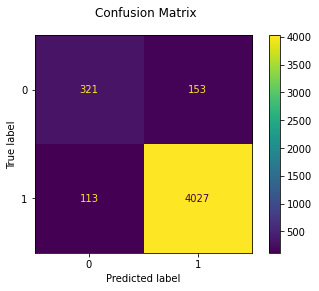

Classification report for classifier DecisionTreeClassifier(class_weight={0: 2.0, 1: 1.0},
                       min_impurity_decrease=0.0001, min_samples_split=20,
                       random_state=0):
              precision    recall  f1-score   support

           0       0.74      0.68      0.71       474
           1       0.96      0.97      0.97      4140

    accuracy                           0.94      4614
   macro avg       0.85      0.82      0.84      4614
weighted avg       0.94      0.94      0.94      4614




In [62]:
# Test on Boulder 20% data

Boulder_nominal = pd.read_pickle("/DATA2/dse313/group15/Boulder/Boulder_Processed_Data/Boulder_nominal_data.pkl")

X = nominal_data[nominal_features]
y = nominal_data["official_type"]

#Boulder_X = pd.read_pickle("./Boulder_Processed_Data/Boulder_X.pkl")
#Boulder_y = pd.read_pickle("./Boulder_Processed_Data/Boulder_y.pkl")

Boulder_X = Boulder_nominal[nominal_features]
Boulder_y = Boulder_nominal["official_type"]

# Split data into 80% train and 20% test subsets
X_train, X_test, y_train, y_test = train_test_split(\
    X, y, test_size=0.2, shuffle=True)

Boulder_X_train, Boulder_X_test, Boulder_y_train, Boulder_y_test = train_test_split(\
    Boulder_X, Boulder_y, test_size=0.2, shuffle=True)

#weights = 'balanced'
weights = {0:2.0, 1:1.0}
dt_split = DecisionTreeClassifier(class_weight=weights,min_samples_split=20, \
                                random_state=0,min_impurity_decrease = 0.0001)

#dt_split = DecisionTreeClassifier(min_samples_split=20, random_state=0,min_impurity_decrease = 0.0001)

# Learn on the train subset
dt_split.fit(X_train, y_train)

# Predict the target on the test subset
predicted = dt_split.predict(Boulder_X_test)

# 1 = RES; 0 = NON_RES

disp = metrics.ConfusionMatrixDisplay.from_predictions(Boulder_y_test, predicted)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

print(
    f"Classification report for classifier {dt_split}:\n"
    f"{metrics.classification_report(Boulder_y_test, predicted)}\n"
)

Confusion matrix:
[[ 1648   734]
 [  426 20261]]


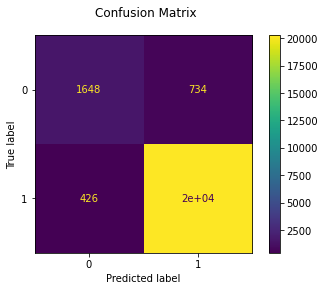

Classification report for classifier DecisionTreeClassifier(class_weight={0: 2.0, 1: 1.0},
                       min_impurity_decrease=0.0001, min_samples_split=20,
                       random_state=0):
              precision    recall  f1-score   support

           0       0.79      0.69      0.74      2382
           1       0.97      0.98      0.97     20687

    accuracy                           0.95     23069
   macro avg       0.88      0.84      0.86     23069
weighted avg       0.95      0.95      0.95     23069




In [63]:
# Test on Boulder 100% data

Boulder_nominal = pd.read_pickle("/DATA2/dse313/group15/Boulder/Boulder_Processed_Data/Boulder_nominal_data.pkl")

X = nominal_data[nominal_features]
y = nominal_data["official_type"]

Boulder_X = Boulder_nominal[nominal_features]
Boulder_y = Boulder_nominal["official_type"]

#weights = 'balanced'
weights = {0:2.0, 1:1.0}
dt_split = DecisionTreeClassifier(class_weight=weights,min_samples_split=20, \
                                random_state=0,min_impurity_decrease = 0.0001)

X_train, X_test, y_train, y_test = train_test_split(\
    X, y, test_size=0.2, shuffle=True)

# Learn on FFX
dt_split.fit(X_train, y_train)

# Predict the target on Boulder
predicted = dt_split.predict(Boulder_X)

# 1 = RES; 0 = NON_RES

disp = metrics.ConfusionMatrixDisplay.from_predictions(Boulder_y, predicted)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

print(
    f"Classification report for classifier {dt_split}:\n"
    f"{metrics.classification_report(Boulder_y, predicted)}\n"
)

In [64]:
output_data = Boulder_nominal.copy()
output_data.drop(columns=['official_type','buffer_cat2_30', 'buffer_cat2_60','buffer_cat2_90'], inplace=True)
output_data.insert(1,'official',Boulder_y)
output_data.insert(2,'predicted',predicted)

In [65]:
output_data.head()

,geometry,official,predicted,buffer_cat1_30,buffer_cat1_60,buffer_cat1_90,buffer_cat3_30,buffer_cat3_60,buffer_cat3_90,buffer_cat4_30,...,yes,cemetery_landuse,construction_landuse,farmyard_landuse,forest_landuse,misc_landuse,no_landuse,non_res_landuse,recreation_ground_landuse,residential_landuse
0,"POLYGON ((-105.26620 40.00586, -105.26620 40.0...",1,0,1,1,1,1,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,"POLYGON ((-105.26486 40.00597, -105.26486 40.0...",1,0,0,0,1,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,"POLYGON ((-105.26486 40.00602, -105.26469 40.0...",1,0,0,1,1,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,"POLYGON ((-105.26461 40.00653, -105.26441 40.0...",1,0,0,0,1,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,"POLYGON ((-105.26530 40.00707, -105.26515 40.0...",1,0,0,1,1,1,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [67]:
#output_filtered.to_file("./Datasets/OSM/Geopandas_Output/filtered_output.shp")
if 'Test_on_Boulder' not in os.listdir("/DATA2/dse313/group15/FFX/"):
    os.mkdir("/DATA2/dse313/group15/FFX/Test_on_Boulder")
output_data.to_file("/DATA2/dse313/group15/FFX/Test_on_Boulder/Boulder_Test_Predictions.shp")

<ipython-input-67-ee1b643aa4b4>:4: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  output_data.to_file("/DATA2/dse313/group15/FFX/Test_on_Boulder/Boulder_Test_Predictions.shp")


In [68]:
#X.to_pickle("./FFX_Processed_Data/FFX_X.pkl") 
#y.to_pickle("./FFX_Processed_Data/FFX_y.pkl")
if 'FFX_Processed_Data' not in os.listdir("/DATA2/dse313/group15/FFX/"):
    os.mkdir("/DATA2/dse313/group15/FFX/FFX_Processed_Data")
nominal_data.to_pickle("/DATA2/dse313/group15/FFX/FFX_Processed_Data/FFX_nominal_data.pkl") 

In [ ]:
# Ablation Study

In [69]:
input_data.columns

Index(['geometry', 'official_type', 'buffer_cat1_30', 'buffer_cat1_60',
       'buffer_cat1_90', 'buffer_cat2_30', 'buffer_cat2_60', 'buffer_cat2_90',
       'buffer_cat3_30', 'buffer_cat3_60', 'buffer_cat3_90', 'buffer_cat4_30',
       'buffer_cat4_60', 'buffer_cat4_90', 'shop', 'website', 'brand',
       'amenity', 'building:levels', 'name', 'addr:street', 'source',
       'building', 'landuse', 'area', 'parking_cat1', 'parking_cat2',
       'parking_cat3', 'parking_cat4', 'parking_cat5', 'parking_cat6',
       'parking_cat7', 'parking_cat8', 'parking_cat9'],
      dtype='object')

In [70]:
ablation_data = input_data.copy()

In [71]:
ablation_data.drop(columns=['buffer_cat1_30', 'buffer_cat1_60',\
                        'buffer_cat1_90', 'buffer_cat2_30', 'buffer_cat2_60', 'buffer_cat2_90',\
                        'buffer_cat3_30', 'buffer_cat3_60', 'buffer_cat3_90', 'buffer_cat4_30',\
                        'buffer_cat4_60', 'buffer_cat4_90',\
                        \
                        \
                        'parking_cat1', 'parking_cat2', 'parking_cat3', 'parking_cat4',\
                        'parking_cat5', 'parking_cat6', 'parking_cat7', 'parking_cat8',\
                        'parking_cat9'], inplace=True)

In [72]:
ablation_data.columns

Index(['geometry', 'official_type', 'shop', 'website', 'brand', 'amenity',
       'building:levels', 'name', 'addr:street', 'source', 'building',
       'landuse', 'area'],
      dtype='object')

In [73]:
# nominal transform

value_tags = ['building','landuse']
#nominal_data = input_data.copy()
#value_tags = ['building']
ablation_data = nominal_transform(ablation_data, value_tags)
ablation_features = list(ablation_data.columns[2:])
ablation_features

/home/dse313/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/dse313/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


['shop',
 'website',
 'brand',
 'amenity',
 'building:levels',
 'name',
 'addr:street',
 'source',
 'area',
 'apartments',
 'church',
 'civic',
 'commercial',
 'construction',
 'detached',
 'dormitory',
 'garage',
 'garages',
 'greenhouse',
 'hospital',
 'hotel',
 'house',
 'industrial',
 'kindergarten',
 'misc_buildings',
 'office',
 'parking',
 'public',
 'residential',
 'retail',
 'roof',
 'school',
 'semidetached_house',
 'service',
 'shed',
 'static_caravan',
 'terrace',
 'warehouse',
 'yes',
 'cemetery_landuse',
 'construction_landuse',
 'farmyard_landuse',
 'forest_landuse',
 'misc_landuse',
 'no_landuse',
 'non_res_landuse',
 'recreation_ground_landuse',
 'residential_landuse']

In [74]:
ablation_data.columns

Index(['geometry', 'official_type', 'shop', 'website', 'brand', 'amenity',
       'building:levels', 'name', 'addr:street', 'source', 'area',
       'apartments', 'church', 'civic', 'commercial', 'construction',
       'detached', 'dormitory', 'garage', 'garages', 'greenhouse', 'hospital',
       'hotel', 'house', 'industrial', 'kindergarten', 'misc_buildings',
       'office', 'parking', 'public', 'residential', 'retail', 'roof',
       'school', 'semidetached_house', 'service', 'shed', 'static_caravan',
       'terrace', 'warehouse', 'yes', 'cemetery_landuse',
       'construction_landuse', 'farmyard_landuse', 'forest_landuse',
       'misc_landuse', 'no_landuse', 'non_res_landuse',
       'recreation_ground_landuse', 'residential_landuse'],
      dtype='object')

In [75]:
ablation_data.shape

(204671, 50)

Confusion matrix:
[[ 1445   583]
 [  160 38747]]


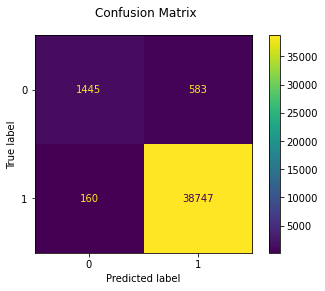

Classification report for classifier DecisionTreeClassifier(class_weight={0: 2.0, 1: 1.0},
                       min_impurity_decrease=0.0001, min_samples_split=20,
                       random_state=0):
              precision    recall  f1-score   support

           0       0.90      0.71      0.80      2028
           1       0.99      1.00      0.99     38907

    accuracy                           0.98     40935
   macro avg       0.94      0.85      0.89     40935
weighted avg       0.98      0.98      0.98     40935




In [76]:
X = ablation_data[ablation_features]
y = ablation_data["official_type"]
weights = {0:2.0, 1:1.0}

# Split data into 80% train and 20% test subsets
X_train, X_test, y_train, y_test = train_test_split(\
    X, y, test_size=0.2, shuffle=True)
dt_split = DecisionTreeClassifier(class_weight=weights,min_samples_split=20, \
                                random_state=0,min_impurity_decrease = 0.0001)

#dt_split = DecisionTreeClassifier(min_samples_split=20, random_state=0,min_impurity_decrease = 0.0001)

# Learn on the train subset
dt_split.fit(X_train, y_train)

# Predict the target on the test subset
predicted = dt_split.predict(X_test)

# 1 = RES; 0 = NON_RES

disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

print(
    f"Classification report for classifier {dt_split}:\n"
    f"{metrics.classification_report(y_test, predicted)}\n"
)